In [1]:
pip install biopython

Note: you may need to restart the kernel to use updated packages.


In [2]:
from Bio import SeqIO
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns
from matplotlib.collections import PathCollection
import geopandas as gpd
import pandas as pd
import numpy as np
import copy
import statistics
from scipy.stats import chisquare, ttest_ind

plt.show()
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [3]:
#get deletion and editing seuqences
def summary(d):
    mean=round(sum(d)/len(d),2)
    med=statistics.median(d)
    mod=statistics.mode(d)
    print(f"mean: {mean}, median: {med}, mode: {mod}, max: {max(d)}, min: {min(d)}")
def read_editing_sites(small_u):
    smallu=SeqIO.to_dict(SeqIO.parse(small_u,'fasta'))
    edits={}
    for k in smallu:
        sites=[0 if b=='u' else 1 for b in smallu[k].seq] #0 for insertions
        edits[k]=sites
    return(edits)
#deletion
def read_deletion_sites(deletion):
    deletion=SeqIO.to_dict(SeqIO.parse(deletion,'fasta'))
    delets={}
    for k in deletion:
        sites=[0 if b!='-' else 1 for b in deletion[k].seq] #0 for deletion sites
        delets[k]=sites
    return(delets)
#
def strain_minis(csv):
    df=pd.read_csv(csv,index_col='renamed') #set a new index
    mini_dict={strain:set(df.loc[strain][~(df.loc[strain].isna())].index) for strain in df.index}
    return(mini_dict)

def get_gRNA_info (txt,csv=False,matches=False):
    with open(txt) as handle:
        keys=[x for x in next(handle).strip('\n').split(' ') if x !='']
        gRNA_dict={[x for x in line.strip('\n').split(' ') if x !=''][17]: {i:j for i,j in zip(keys,[x for x in line.strip('\n').split(' ') if x !=''][1:])}for line in handle}
        mRNA_dict={gRNA_dict[key]['mRNA_name']:[] for key in gRNA_dict}
        for key in gRNA_dict:
            x1=int(gRNA_dict[key]['mRNA_start'])
            x2=int(gRNA_dict[key]['mRNA_end'])
            x3=int(gRNA_dict[key]['anchor_len'])
            mRNA_dict[gRNA_dict[key]['mRNA_name']].append((x1,x2,x3))
        if matches != False:
            #matches='/home/jovyan/minicircle_annotation/Tbg1_cleaned_minicircles.log'
            match_dict={list(filter(None,l.strip('\n').split(' ')))[0]:list(filter(None,l.strip('\n').split(' ')))[1] for l in open(matches)} #translate mini naming system
            for k in gRNA_dict:
                gRNA_dict[k]['mO_name']=match_dict[gRNA_dict[k]['mO_name']]
    #assign minicircle/gRNAs to each strain (using old copy number analysis)
    def assign_gRNA(csv,gRNA_dict):
        df=pd.read_csv(csv,index_col='renamed') #set a new index
        strain_mrna,strain_grna={},{}
        for strain in df.index:
            empty_mRNA_dict={gRNA_dict[key]['mRNA_name']:[] for key in gRNA_dict}
            minis=set(df.loc[strain][~(df.loc[strain].isna())].index)
            strain_mrna[strain]=empty_mRNA_dict
            strain_grna[strain]={}
            for key,v in gRNA_dict.items():
                if gRNA_dict[key]['mO_name'] in minis:
                    x1=int(gRNA_dict[key]['mRNA_start'])
                    x2=int(gRNA_dict[key]['mRNA_end'])
                    x3=int(gRNA_dict[key]['anchor_len'])
                    strain_mrna[strain][gRNA_dict[key]['mRNA_name']].append((x1,x2,x3))
                    strain_grna[strain][key]=v
                    #print(len(strain_mrna[strain][gRNA_dict[key]['mRNA_name']]),strain,gRNA_dict[key]['mRNA_name'])
        return(strain_mrna,strain_grna)
    if csv!=False:
        strain_mrna,strain_grna=assign_gRNA(csv,gRNA_dict)
        return(strain_mrna,strain_grna) 
    else:
        return(mRNA_dict,gRNA_dict)

def find_gap2(dictionary,insertions,key): #mrna_dict
    gaps,edits=[],copy.deepcopy(insertions[key])
    for i in sorted(dictionary[key]):
        for site in range(i[0],i[1]-6):
            edits[site]+=1
    x=[i for i,j in enumerate(edits) if j ==0]
    return(x)

def draw_grna(coor,adj=0,y=0.5,color='blue'):
    xstart=int(coor[0])-adj
    xend=int(coor[1])-adj
    anchor_len=int(coor[2])
    hl=(xend-xstart)/10
    plt.arrow(xend,y,-anchor_len,0,head_width=0, head_length=0, width=0.2,fc='red', ec='None',alpha=0.5) #draw anchor
    plt.arrow(xend-anchor_len,y,(xstart-xend+anchor_len+hl),0,head_width=0.2, head_length=hl, width=0.2,fc=color, ec=color,alpha=0.5)
    #plt.vlines(xstart,1,y,colors='k',linestyles='dashed',alpha=0.4)

def plot_alignment(dictionary,key,y=1,adj=0,arrowcolor='skyblue',up=False,fold=3):
    yheight,count,y0=len(dictionary[key])/fold,0,y
    for coor in sorted(dictionary[key],key=lambda x:x[1]):
        draw_grna(coor,adj,y=y,color=arrowcolor)
        count+=1
        if up == False:
            y-=0.2
        else:
            y+=0.2
        if count >= yheight:
            ymin=y
            y=y0
            count=0
    return(ymin)
    
def gRNA_depth(mRNA,mrna_dict,key):
    total=np.array([0]*len(mRNA))
    for pair in mrna_dict[key]:
        total+=np.array([0]*(pair[0]-1)+[1]*(pair[1]-pair[0]-8+1)+[0]*(len(mRNA)-pair[1]+8)) #-8 instead -pair[2]
    return(total)

def plot_mRNA_gRNA(strain_mrna,mini_dict,key,lw=4, #mRNA-dicts+strain--> strain_mrna
                   y=0.1,adj=0,arrowcolor='black',up=False,fold=3,figw=20,figh=10,output='mRNA_coverage'): #with dots
    #
    insertions=read_editing_sites(small_u)
    deletion=read_deletion_sites(dels)
    fig,axs = plt.subplots(1,1,figsize=(figw,figh))   
    start=-0.3
    ymin=0
    #draw insertion sites: 0 for insertions
    x=[i for i,c in enumerate(insertions[key]) if c==0 ] 
    y=[ymin]*len(x)
    axs.scatter(x,y,marker=3,color='purple',linewidth=5)
    ymin-=1
    #draw deletions
    x=[i for i,c in enumerate(deletion[key]) if c==0 ] 
    y=[ymin]*len(x)
    axs.scatter(x,y,marker=3,color='red',linewidth=5)
    ymin+=-1
    #find the last editing site
    last1,last2=0,0
    for i,b in enumerate(deletion[key]):
        if b=='0':
            last1=i
    for i,b in enumerate(insertions[key]):
        if b=='0':
            last2=i
    last=max(last1,last2)
    #plot gRNA alignment
    gaps,gap_dict=[],{}
    for strain in strain_mrna:
        ymin-=2
        mRNA_dict=strain_mrna[strain]
        yprevious=ymin
        y=ymin
        ymin=plot_alignment(mRNA_dict,key,y,adj,arrowcolor,up,fold)
        axs.hlines(ymin,0,len(insertions[key]),colors='k',linestyles='dashed',alpha=0.4)
        if mini_dict.get(strain,'') != '':
            mininum=len(mini_dict.get(strain,''))
        else:
            mininum='NA'
        axs.text(0,ymin,f"{strain} ({mininum})",fontsize=25)
        y=ymin-0.5
        #plot gRNA coverage on mRNA
        #grna_depth=gRNA_depth(mRNA,mRNA_dict,key) 
        #axs.plot(range(len(mRNA)),grna_depth,label=f'gRNA coverage {strain}')
        x=find_gap2(mRNA_dict,insertions,key)
        if x !='[]':
            axs.plot(x,[yprevious+1]*len(x),'^',color='black')
            for i in x:
                axs.vlines(i,yprevious+1,ymin,colors='k',linestyles='dashed',alpha=0.4)
        #print(find_gap(mRNA_dict,key),ymin,yprevious)
    #plot borders of gRNA coverage gaps
    #gaps=find_gap(mRNA_dict,key)
    #if the last editing sites are covered:
    axs.tick_params(axis='y', labelsize= 15)
    axs.get_yaxis().set_visible(False)
    #axs.set_facecolor("white")
    #plt.xticks([])
    #plt.yticks([])
    plt.savefig(f'Outfiles/{output}.pdf', format="pdf", bbox_inches="tight")
    plt.show()
    return(insertions)


In [4]:
def split_dict(size,dictionary):
    keys,dict_list=list(dictionary.keys()),[]
    for i in range(0,len(dictionary)+1,size):
        dict_list.append({k:dictionary[k] for k in keys[i:i+size]})
    return(dict_list)
        

In [5]:
small_u='/home/jovyan/Minicircle_gRNA_families/In_files/Tbg_340AT_Antat_edited_mRNA_small_u.fasta'
dels='/home/jovyan/Minicircle_gRNA_families/In_files/Tbg_340AT_Antat_deletions_mRNA.txt'
#dels='/home/jovyan/Tbg1_Tbb_Tbr_minicircle_annotation/Infiles/deletions_mRNA.txt'
mrna_OVI,grna_OVI=get_gRNA_info ('/home/jovyan//Tbeqev/Infiles/OVI_gRNAs_2024-09-20.txt')
mrna_eatro1125, grna_eatro1125=get_gRNA_info('/home/jovyan/gRNAs/gRNA_Tbb.txt')
mrna_340,grna_340=get_gRNA_info('/home/jovyan/Minicircle_gRNA_families/In_files/Tbg_340AT_Antat_gRNAs.txt')

In [6]:
strain_mrna,strain_grna=get_gRNA_info ('/home/jovyan//Minicircle_gRNA_families/In_files/Tbg1_gRNAs_2024-05-17.txt',
                                  '/home/jovyan/Tbg1_Tbb_Tbr_minicircle_annotation/Tbg1_minicircles.csv',
                                  '/home/jovyan/Minicircle_gRNA_families/In_files/Tbg1_cleaned_minicircles.log') 
mini_dict=strain_minis('/home/jovyan/Tbg1_Tbb_Tbr_minicircle_annotation/Tbg1_minicircles.csv')

In [7]:
len(mini_dict['TbgI_LiTat-1-3'])

52

In [8]:
dict_list=split_dict(10,strain_mrna)
selected=['TbgI_340AT','TbgI_LiTat-1-3','TbgI_KIN-1'] #['TbgI_340AT','TbgI_LiTat-1-3','TbgI_LiTat-1-5-P9','TbgI_Bosendja','TbgI_KIN-1']
selected_dict={k:strain_mrna[k] for k in selected}
selected2=['TbgI_340AT','TbgI_LiTat-1-3']
selected_dict2={k:strain_mrna[k] for k in selected2}
selected_dict2['Tbeq_OVI']=mrna_OVI
strain_mrna['Tbb_EATRO1125']=mrna_eatro1125
strain_mrna['Tbeq_OVI']=mrna_OVI
strain_mrna['TbgI_340AT']=mrna_340
grna_litat=strain_grna['TbgI_LiTat-1-3']

In [9]:
#number of minicircles with A6 or RPS12 in type OVI
a6rps12=set([v['mO_name'] for k,v in grna_eatro1125.items() if v['product'] in ['A6']])
len(a6rps12)#/399
#len(set([v['mO_name'] for k,v in grna_eatro1125.items()]))

111

In [10]:
#OVI: A6 RPS12 enrichment
def chisequare_func(obsq,obstotal,expq,exptotal):
    f_exp = np.array([expq,exptotal-expq]) / exptotal*obstotal
    f_obs= [obsq,obstotal-obsq]
    a=chisquare(f_obs=f_obs, f_exp=f_exp)
    print(a)


#gRNA enrichment,A6
chisequare_func(31,115,135,994)
#gRNA enrichment RPS12
chisequare_func(11,115,62,994)
#minicircle enrichment A6 and RPS12
chisequare_func(34,46,161,339)
#minicircle enrichment A6 
chisequare_func(len(set([v['mO_name'] for k,v in grna_OVI.items() if v['product'] in ['A6']])),46,len(set([v['mO_name'] for k,v in grna_eatro1125.items() if v['product'] in ['A6']])),339)
#minicircle enrichment RPS12
chisequare_func(len(set([v['mO_name'] for k,v in grna_OVI.items() if v['product'] in ['RPS12']])),46,len(set([v['mO_name'] for k,v in grna_eatro1125.items() if v['product'] in ['RPS12']])),339)

Power_divergenceResult(statistic=17.52804133181114, pvalue=2.8310140118280675e-05)
Power_divergenceResult(statistic=2.1775872966188925, pvalue=0.1400338367285832)
Power_divergenceResult(statistic=12.876289191575616, pvalue=0.00033277141094502946)
Power_divergenceResult(statistic=11.81037788360443, pvalue=0.0005890147640267555)
Power_divergenceResult(statistic=0.377777932416634, pvalue=0.5387948549223753)


In [11]:
def process_df(csv,meta2):
    df=pd.read_csv(csv,index_col=0)#.rename(columns=df.iloc[0]).drop(df.index[0])
    df=df.drop(['MSUS-CI-78-TSW390','GUIWI-BOBO80-MURAZ18','SN54-TREU96']) #remove the known contaminated samples and Tbeq
    #clean up metadata
    metadf2=pd.read_csv(meta2,index_col=0,encoding='cp1252') #not utf8 encoding
    try:
        metadf2=metadf2.drop(['MSUS-CI-78-TSW390','GUIWI-BOBO80-MURAZ18','SitaBip1','SN54-TREU96','ABBA_b'])
    except:
        print('already removed')
    metadf2['taxon']=metadf2['taxon'].fillna('T. brucei').replace('T.b.','T. brucei')
    metadf2.rename(columns={'Year of isolation ': 'Year of isolation'}, inplace=True)
    metadf2['continent']=metadf2['continent'].fillna('na').replace('Southern Africa\xa0','Southern Africa')
    metadf2['country']=metadf2['country'].fillna('na')
    metadf2['Year of isolation']=metadf2['Year of isolation'].fillna('na')
    for s in ['MHOM-CI-78-DALOA72-cloneA','MHOM-CI-79-DALOA74','MHOM-CI-91-SIQUE1623','MHOM-ZR-71-C126','MSUS-CI-82-TSW125-KP1-cloneB']:
        metadf2.loc[s,'taxon']='T.b. gambiense type I'
    for s in ['MSUS-CI-78-TSW168']:
        metadf2.loc[s,'taxon']='T.b. gambiense type II'
    for s in ['MSUS-CI-78-TSW178','MSUS-CI-78-TSW38-021','MSUS-CI-78-TSW382-bis']:
        metadf2.loc[s,'taxon']='T.b. brucei'
    #Zambia is assigned to EA and SA --> assign all Zambia to SA
    for s in metadf2[metadf2.apply(lambda x:x['country']=='Zambia' and x['continent']=='East Africa', axis=1)].index:
        metadf2.loc[s,'continent']='Southern Africa'
    #ignore Tbeq Tbev data for now
    metadf2=metadf2.loc[metadf2.index.intersection(df.index)]
    #combine
    combined=pd.concat([df,metadf2], axis=1) #append won't change the order of columns (no auto sorting)
    renames=rename_strain(combined)
    combined['renamed']=renames
    combined=combined.set_index('renamed')
    return(metadf2,combined)
def rename_strain(df):
    new=[]
    taxon_dict={'T.b. gambiense type I':'TbgI','T.b. gambiense type II':'TbgII',
                              'T.b. brucei':'Tbb','T.b. rhodesiense':'Tbr',
                             'T.b.':'Tb','T. brucei':'Tb'}
    for i,j in zip(df.index,df['taxon']):
        if j in taxon_dict:
            new.append(f'{taxon_dict[j]}_{i}')
        else:
            new.append(f'Tb_{i}')
    return(new)

In [12]:
#LiTat-1-3: A6 RPS12 enrichment
#gRNA enrichment,A6
chisequare_func(38,192,135,994)
#gRNA enrichment RPS12
chisequare_func(9,192,62,994)
#minicircle enrichment A6 and RPS12
#chisequare_func(,51,161,339)
#minicircle enrichment A6 
chisequare_func(len(set([v['mO_name'] for k,v in grna_litat.items() if v['product'] in ['A6']])),52,len(set([v['mO_name'] for k,v in grna_eatro1125.items() if v['product'] in ['A6']])),339)
#minicircle enrichment RPS12
chisequare_func(len(set([v['mO_name'] for k,v in grna_litat.items() if v['product'] in ['RPS12']])),52,len(set([v['mO_name'] for k,v in grna_eatro1125.items() if v['product'] in ['RPS12']])),339)
#copy number
csv='/home/jovyan/Minicircle_gRNA_families/In_files/Tb_copy_number_norm2_maxi30.20240209.csv'
meta2='/home/jovyan/Minicircle_gRNA_families/In_files/all_annotated_metadata_isolates_2024-09-02.csv'
metadf2,combined=process_df(csv,meta2)
#
allmini=set([i for i in combined.loc['TbgI_LiTat-1-3'][combined.loc['TbgI_LiTat-1-3'].notna()].index if 'Tb_mO' in i])
litata6rps12=set([v['mO_name'] for k,v in grna_litat.items() if v['product'] in ['A6','RPS12']])
#print(all_mini,len(litata6rps12.intersection(all_mini)),len(litata6rps12))
for s in ['TbgI_LiTat-1-3','TbgI_LiTat-1-5-P9']:
    litata6rps12_cpnb=[combined.loc[s][m] for m in litata6rps12.intersection(allmini)]
    other=allmini.difference(litata6rps12)
    other_cpnb={m: combined.loc[s].fillna(0)[m] for m in other if combined.loc[s][m]}
    othercpnb=[v for v in other_cpnb.values() if v !=0]
    a=ttest_ind(litata6rps12_cpnb,othercpnb)
    print(s,a,summary(litata6rps12_cpnb),summary(othercpnb))

Power_divergenceResult(statistic=6.308921513675107, pvalue=0.012013189392735778)
Power_divergenceResult(statistic=0.788655813027828, pvalue=0.37450688781335095)
Power_divergenceResult(statistic=14.697696684538794, pvalue=0.0001262005518454121)
Power_divergenceResult(statistic=0.044914064808431076, pvalue=0.8321621242708296)
already removed
mean: 29.47, median: 14.68, mode: 8.01, max: 109.89, min: 1.61
mean: 64.37, median: 54.31, mode: 108.29, max: 110.46, min: 1.68
TbgI_LiTat-1-3 TtestResult(statistic=-3.2379343856224794, pvalue=0.0021407232880974025, df=50.0) None None
mean: 38.38, median: 23.34, mode: 6.32, max: 153.85, min: 1.1
mean: 87.5, median: 75.73, mode: 154.38, max: 154.57, min: 5.33
TbgI_LiTat-1-5-P9 TtestResult(statistic=-3.3920561725845912, pvalue=0.0013801293029897042, df=49.0) None None


In [13]:

combined.loc['TbgI_LiTat-1-3']['Tb_mO_3435']

nan

In [14]:
#copy number: more abundant minicircles with A6 and RPS12?
df=pd.read_csv('/home/jovyan/Tbg1_Tbb_Tbr_minicircle_annotation/Tbeqev_copynb.csv',header=0)
df.index=df['Unnamed: 0']
df=df.fillna(0)
cpnb=df.to_dict(orient='dict')
cpnb.pop('Unnamed: 0')
matches='/home/jovyan//Tbeqev/Infiles/cleaned_minicircles.log'
matches={[i for i in l.strip('\n').split(' ') if i !=''][0]:l.strip('\n').split(' ')[-1] for l in open(matches)}
#with A6 or RPS12
allmini=set([m for m in df.index if 'OVI_minicircle' in m or m in ['type_A','type_B','type_C','type_A_related']])
ovibsf=set([v['mO_name'] for k,v in grna_OVI.items() if v['product'] in ['A6','RPS12']])
ovibsf=set([matches[m] for m in ovibsf])
for s in ['940','OVI','Te-Ap-N-D1']:
    ovibsf_cpnb=[cpnb[s][m] for m in ovibsf]
    oviother=allmini.difference(ovibsf)
    oviother_cpnb={m: cpnb[s].get(m,0) for m in oviother if m not in ['Maxicircle'] and cpnb[s].get(m,0)!=0}
    a=ttest_ind(ovibsf_cpnb,list(oviother_cpnb.values()))
    print(s,a)

940 TtestResult(statistic=-0.47675287284513207, pvalue=0.6359520895418653, df=43.0)
OVI TtestResult(statistic=-0.46058882266944673, pvalue=0.6474146046352363, df=43.0)
Te-Ap-N-D1 TtestResult(statistic=-0.6764405699188939, pvalue=0.5023835306577371, df=43.0)


In [15]:

#allmini=set([matches[m] for m in allmini if 'OVI_minicircle' in m or m in ['type_A','type_B','type_C','type_A_related']])
len(allmini)
#matches

49

In [16]:
#minicmal copy number of A6/RPS12 mini vs other 
match_back={v:k for k,v in matches.items()}
for s in ['940','OVI','Te-Ap-N-D1','Te-Ap-N-D1-bis']:
    ovibsf_cpnb=[cpnb[s][m] for m in ovibsf]
    oviother=allmini.difference(ovibsf)
    oviother_cpnb={m: cpnb[s].get(m,0) for m in oviother if m not in ['Maxicircle'] and cpnb[s].get(m,0)!=0}
    print(f"{s}: minimal A6/RPS12; {min(ovibsf_cpnb)}")
    print('other<1:',{match_back.get(m,m):v for m,v in oviother_cpnb.items() if v<1})

940: minimal A6/RPS12; 1.39
other<1: {'mO_001': 0.44}
OVI: minimal A6/RPS12; 1.87
other<1: {'mO_010': 0.18}
Te-Ap-N-D1: minimal A6/RPS12; 1.55
other<1: {'mO_046': 0.86, 'type_C': 0.05}
Te-Ap-N-D1-bis: minimal A6/RPS12; 1.19
other<1: {'type_C': 0.15}


In [41]:
#biased quality of A6 and RPS12 gRNAs
def comparison_between_isolates(grna1,grna2,s1,s2,parameter,xlabel):
    print(f'compare {s1} and {s2} OTHER gRNAs {parameter}')
    lena6rps12={g:int(v[parameter]) for g,v in grna1.items() if v['product'] not in ['A6','RPS12']}
    lenother={g:int(v[parameter]) for g,v in grna2.items() if v['product'] not in ['A6','RPS12']}
    print(sum(lena6rps12.values())/len(lena6rps12),statistics.stdev(lena6rps12.values()))
    print(sum(lenother.values())/len(lenother),statistics.stdev(lenother.values()))
    a=ttest_ind(list(lena6rps12.values()),list(lenother.values()))
    print(a)
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5, 5), sharey=True)
    axs.hist(lena6rps12.values(),bins=range(0,round(max(lena6rps12.values())),2),alpha=0.5,label=f'{s1}: other gRNAs')
    axs.hist(lenother.values(),bins=range(0,round(max(lenother.values())),2),alpha=0.5,label= f'{s2}: other gRNAs')
    axs.set_xlabel(f'{xlabel} (nt)')
    axs.set_ylabel('gRNA count')
    axs.legend()
    plt.show()
    print(f'compare {s1} and {s2} A6/RPS12 gRNAs {parameter}')
    lena6rps12={g:int(v[parameter]) for g,v in grna1.items() if v['product'] in ['A6','RPS12']}
    lenother={g:int(v[parameter]) for g,v in grna2.items() if v['product'] in ['A6','RPS12']}
    print(sum(lena6rps12.values())/len(lena6rps12),statistics.stdev(lena6rps12.values()))
    print(sum(lenother.values())/len(lenother),statistics.stdev(lenother.values()))
    a=ttest_ind(list(lena6rps12.values()),list(lenother.values()))
    print(a)
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5, 5), sharey=True)
    axs.hist(lena6rps12.values(),bins=range(0,round(max(lena6rps12.values())),2),alpha=0.5,label=f'{s1}: A6 and RPS12 gRNAs')
    axs.hist(lenother.values(),bins=range(0,round(max(lenother.values())),2),alpha=0.5,label= f'{s2}: A6 and RPS12 gRNAs')
    axs.set_xlabel(f"{xlabel} (nt)")
    axs.set_ylabel('gRNA count')
    axs.legend()
    plt.show()
    #other gRNAs
    #length of gRNAs   Litat 
def comparison_within_isolate(grna,s,parameter,xlabel):
    print(f'compare {s} A6/RPS12 vs other gRNAs {parameter}')
    lena6rps12={g:int(v[parameter]) for g,v in grna.items() if v['product'] in ['A6','RPS12']}
    lenother={g:int(v[parameter]) for g,v in grna.items() if v['product'] not in ['A6','RPS12']}
    print('A6/RPS12 gRNA mean:',sum(lena6rps12.values())/len(lena6rps12),statistics.stdev(lena6rps12.values()))
    print('other gRNA mnea',sum(lenother.values())/len(lenother),statistics.stdev(lenother.values()))
    a=ttest_ind(list(lena6rps12.values()),list(lenother.values()))
    print(a)
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5, 5), sharey=True)
    axs.hist(lena6rps12.values(),bins=range(0,round(max(lena6rps12.values())),1),alpha=0.5,label=f'{s}: A6 and RPS12 gRNAs')
    axs.hist(lenother.values(),bins=range(0,round(max(lenother.values())),1),alpha=0.5,label= f'{s}: other gRNAs')
    axs.set_xlabel(f"{xlabel} (nt)")
    step=round(max(lenother.values())/8)
    if step<1:
        step=2
    axs.set_xticks(range(0,round(max(lenother.values())),step) )
    axs.set_ylabel('gRNA count')
    axs.legend()
    plt.show()

compare OVI A6/RPS12 vs other gRNAs length
A6/RPS12 gRNA mean: 42.61643835616438 4.405268742547261
other gRNA mnea 39.379746835443036 6.225060595870975
TtestResult(statistic=3.672784763911503, pvalue=0.000333141996221503, df=150.0)


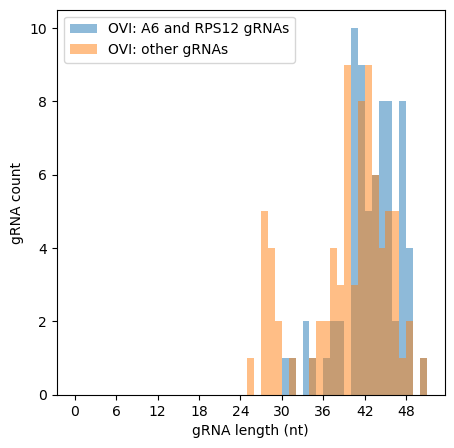

In [42]:
comparison_within_isolate(grna_OVI,'OVI','length','gRNA length')

compare OVI A6/RPS12 vs other gRNAs mismatches
A6/RPS12 gRNA mean: 0.2602739726027397 0.47221103039830886
other gRNA mnea 0.6075949367088608 0.8685047793587012
TtestResult(statistic=-3.027730425315169, pvalue=0.0029013663588234664, df=150.0)


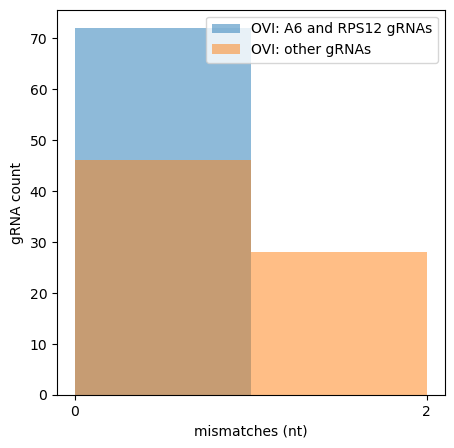

compare OVI A6/RPS12 vs other gRNAs anchor_len
A6/RPS12 gRNA mean: 12.36986301369863 2.8013233445952155
other gRNA mnea 11.215189873417721 2.649000227836084
TtestResult(statistic=2.6117769046734907, pvalue=0.009922788225604036, df=150.0)


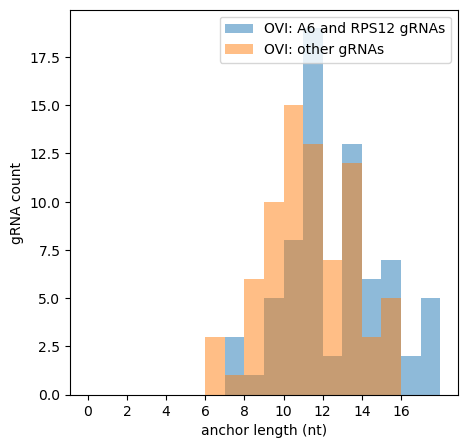

In [43]:
comparison_within_isolate(grna_OVI,'OVI','mismatches','mismatches')
comparison_within_isolate(grna_OVI,'OVI','anchor_len','anchor length')


compare EATRO1125 A6/RPS12 vs other gRNAs length
A6/RPS12 gRNA mean: 40.91925465838509 5.495934668926009
other gRNA mnea 40.04642857142857 5.320389332823114
TtestResult(statistic=2.4800192024359555, pvalue=0.013278628169882433, df=1160.0)


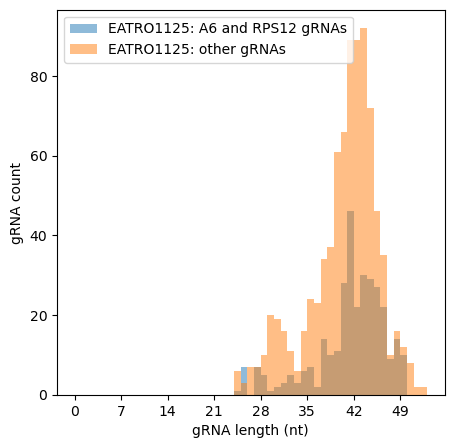

In [44]:
comparison_within_isolate(grna_eatro1125,'EATRO1125','length','gRNA length')

compare EATRO1125 A6/RPS12 vs other gRNAs mismatches
A6/RPS12 gRNA mean: 0.4720496894409938 0.7325295379730558
other gRNA mnea 0.5369047619047619 0.787912218676442
TtestResult(statistic=-1.2800830016476366, pvalue=0.20077187335748367, df=1160.0)


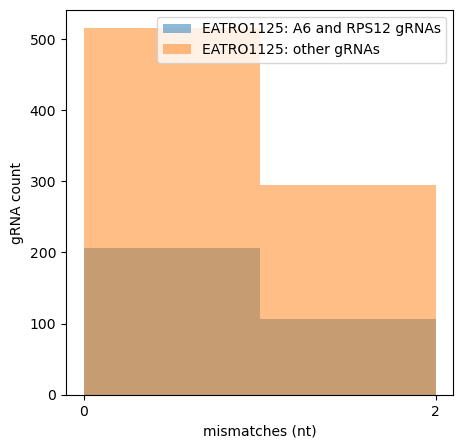

compare EATRO1125 A6/RPS12 vs other gRNAs anchor_len
A6/RPS12 gRNA mean: 11.540372670807454 2.5843858705645197
other gRNA mnea 11.352380952380953 2.5705064216069045
TtestResult(statistic=1.1141273865592511, pvalue=0.2654553292398488, df=1160.0)


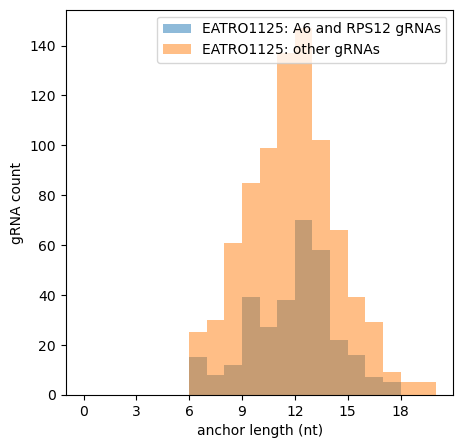

In [45]:
comparison_within_isolate(grna_eatro1125,'EATRO1125','mismatches','mismatches')
comparison_within_isolate(grna_eatro1125,'EATRO1125','anchor_len','anchor length')

compare LiTat-1-3 A6/RPS12 vs other gRNAs length
A6/RPS12 gRNA mean: 41.2625 4.536054578512092
other gRNA mnea 38.455089820359284 5.850246196885466
TtestResult(statistic=3.7807421843553826, pvalue=0.0001964868387049928, df=245.0)


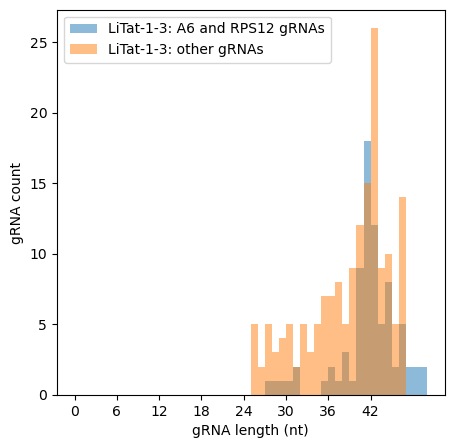

In [46]:
comparison_within_isolate(grna_litat,'LiTat-1-3','length','gRNA length')

compare LiTat-1-3 A6/RPS12 vs other gRNAs mismatches
A6/RPS12 gRNA mean: 0.4 0.7564072307521771
other gRNA mnea 0.5449101796407185 0.8829481477656197
TtestResult(statistic=-1.262403490065739, pvalue=0.20800394251447724, df=245.0)


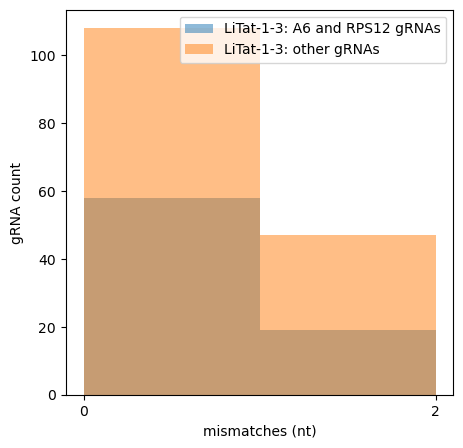

compare LiTat-1-3 A6/RPS12 vs other gRNAs anchor_len
A6/RPS12 gRNA mean: 12.1875 3.2260559060346057
other gRNA mnea 11.071856287425149 2.6966486614534464
TtestResult(statistic=2.8509361441743697, pvalue=0.004730558101465045, df=245.0)


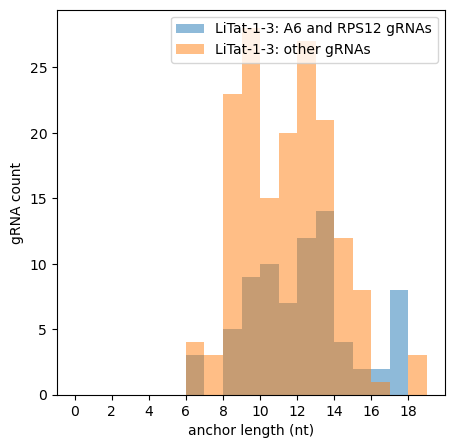

In [47]:
comparison_within_isolate(grna_litat,'LiTat-1-3','mismatches','mismatches')
comparison_within_isolate(grna_litat,'LiTat-1-3','anchor_len','anchor length')

compare OVI and EATRO1125 OTHER gRNAs length
39.379746835443036 6.225060595870975
40.04642857142857 5.320389332823114
TtestResult(statistic=-1.048479389591667, pvalue=0.2946940501497434, df=917.0)


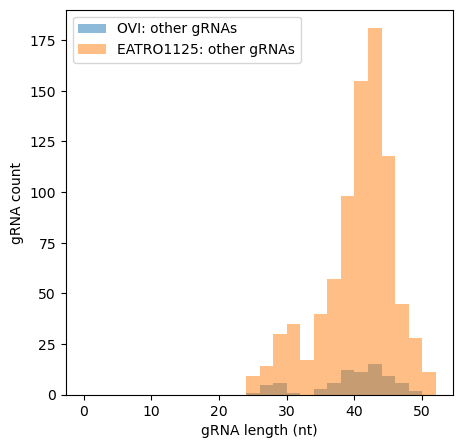

compare OVI and EATRO1125 A6/RPS12 gRNAs length
42.61643835616438 4.405268742547261
40.91925465838509 5.495934668926009
TtestResult(statistic=2.464269993251131, pvalue=0.01415639234955752, df=393.0)


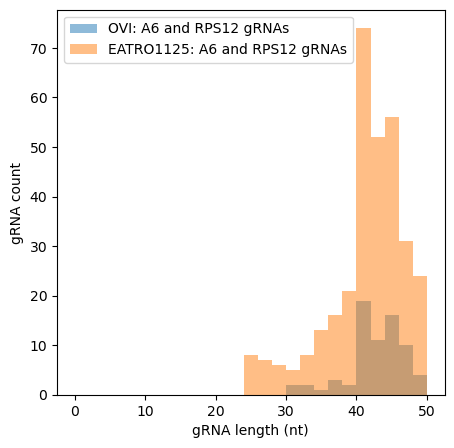

In [24]:
#OVI vs EATRO1125
comparison_between_isolates(grna_OVI,grna_eatro1125,'OVI','EATRO1125','length','gRNA length')


compare OVI and EATRO1125 OTHER gRNAs mismatches
0.6075949367088608 0.8685047793587012
0.5369047619047619 0.787912218676442
TtestResult(statistic=0.7555108912601967, pvalue=0.4501365122209475, df=917.0)


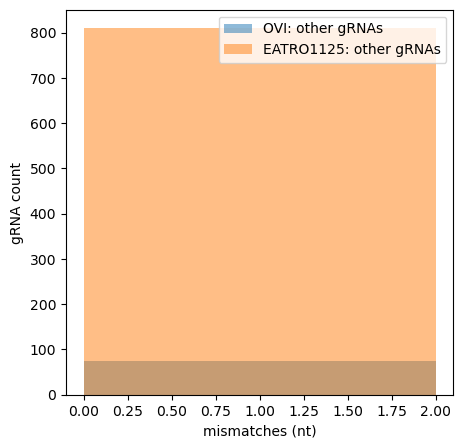

compare OVI and EATRO1125 A6/RPS12 gRNAs mismatches
0.2602739726027397 0.47221103039830886
0.4720496894409938 0.7325295379730558
TtestResult(statistic=-2.3601214685399157, pvalue=0.018756851524499612, df=393.0)


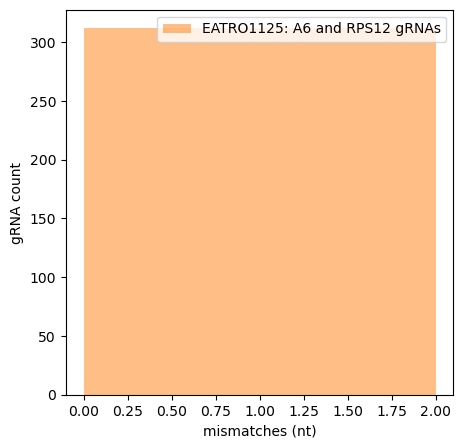

compare OVI and EATRO1125 OTHER gRNAs anchor_len
11.215189873417721 2.649000227836084
11.352380952380953 2.5705064216069045
TtestResult(statistic=-0.45233516685276204, pvalue=0.6511345286222991, df=917.0)


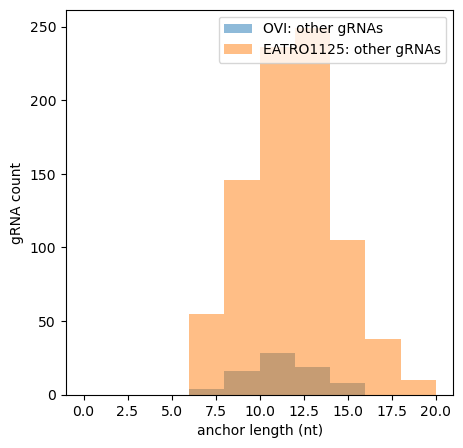

compare OVI and EATRO1125 A6/RPS12 gRNAs anchor_len
12.36986301369863 2.8013233445952155
11.540372670807454 2.5843858705645197
TtestResult(statistic=2.437220477756611, pvalue=0.015243420841654245, df=393.0)


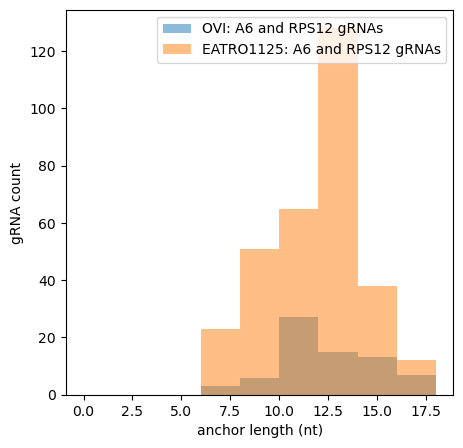

In [25]:
comparison_between_isolates(grna_OVI,grna_eatro1125,'OVI','EATRO1125','mismatches','mismatches')
comparison_between_isolates(grna_OVI,grna_eatro1125,'OVI','EATRO1125','anchor_len','anchor length')


compare OVI and LiTat OTHER gRNAs length
39.379746835443036 6.225060595870975
38.455089820359284 5.850246196885466
TtestResult(statistic=1.133756657790752, pvalue=0.25800933144339716, df=244.0)


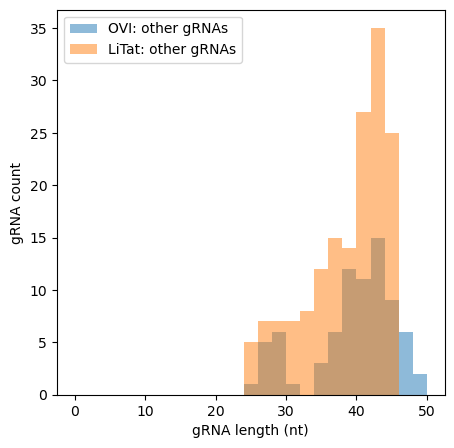

compare OVI and LiTat A6/RPS12 gRNAs length
42.61643835616438 4.405268742547261
41.2625 4.536054578512092
TtestResult(statistic=1.869593194320205, pvalue=0.06347663348463688, df=151.0)


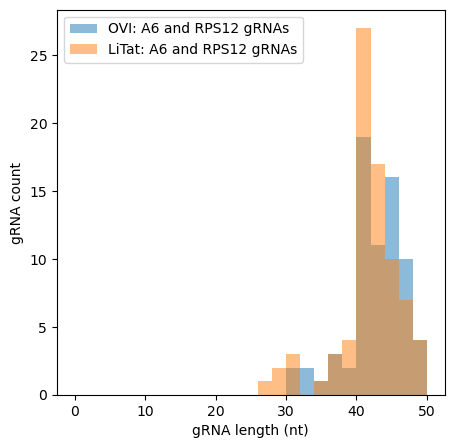

compare OVI and LiTat OTHER gRNAs anchor_len
11.215189873417721 2.649000227836084
11.071856287425149 2.6966486614534464
TtestResult(statistic=0.3914469905860936, pvalue=0.6958084915479554, df=244.0)


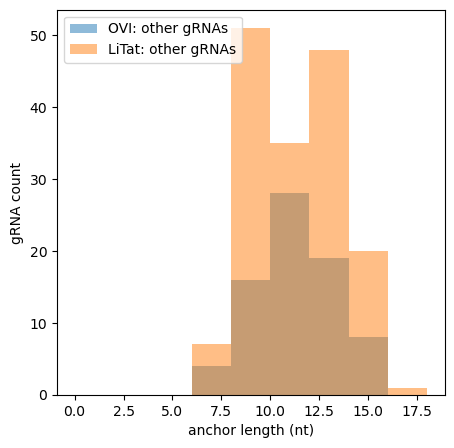

compare OVI and LiTat A6/RPS12 gRNAs anchor_len
12.36986301369863 2.8013233445952155
12.1875 3.2260559060346057
TtestResult(statistic=0.37172024503473783, pvalue=0.7106222481967926, df=151.0)


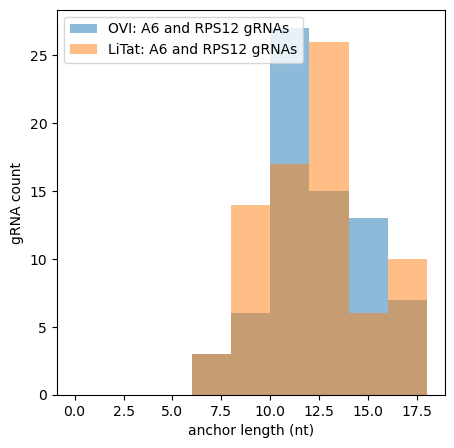

compare OVI and LiTat OTHER gRNAs mismatches
0.6075949367088608 0.8685047793587012
0.5449101796407185 0.8829481477656197
TtestResult(statistic=0.5226310297525174, pvalue=0.6017052500291081, df=244.0)


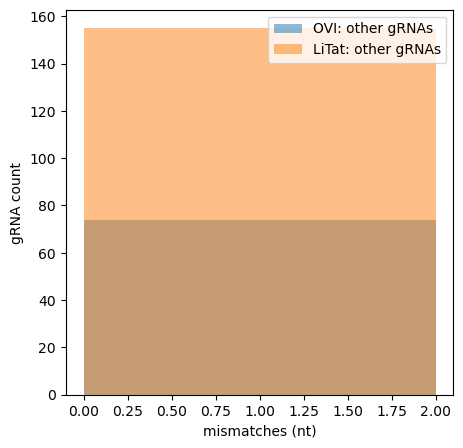

compare OVI and LiTat A6/RPS12 gRNAs mismatches
0.2602739726027397 0.47221103039830886
0.4 0.7564072307521771
TtestResult(statistic=-1.3553655718140363, pvalue=0.17732501553962446, df=151.0)


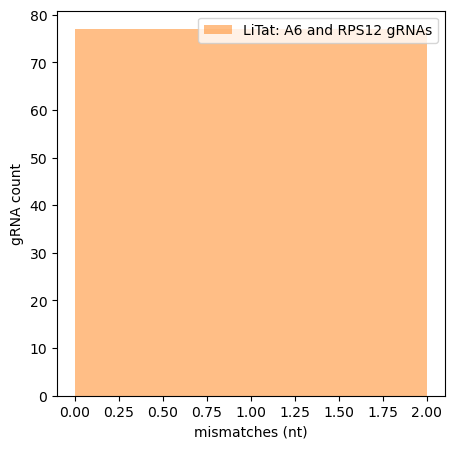

In [26]:
#OVI vs Litat
comparison_between_isolates(grna_OVI,grna_litat,'OVI','LiTat','length','gRNA length')
comparison_between_isolates(grna_OVI,grna_litat,'OVI','LiTat','anchor_len','anchor length')
comparison_between_isolates(grna_OVI,grna_litat,'OVI','LiTat','mismatches','mismatches')

compare EATRO1125 and LiTat OTHER gRNAs length
40.04642857142857 5.320389332823114
38.455089820359284 5.850246196885466
TtestResult(statistic=3.4707971847443506, pvalue=0.000540971037729629, df=1005.0)


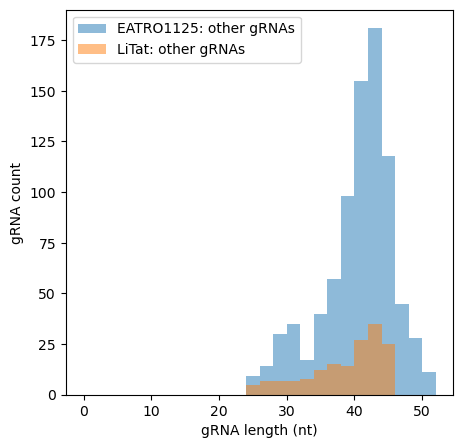

compare EATRO1125 and LiTat A6/RPS12 gRNAs length
40.91925465838509 5.495934668926009
41.2625 4.536054578512092
TtestResult(statistic=-0.5164695372398173, pvalue=0.6058119134585481, df=400.0)


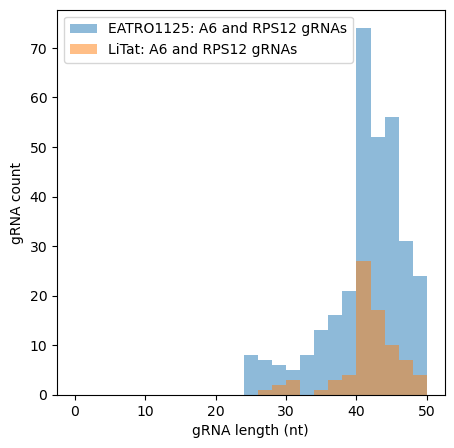

compare EATRO1125 and LiTat OTHER gRNAs anchor_len
11.352380952380953 2.5705064216069045
11.071856287425149 2.6966486614534464
TtestResult(statistic=1.277493047961468, pvalue=0.2017232590810262, df=1005.0)


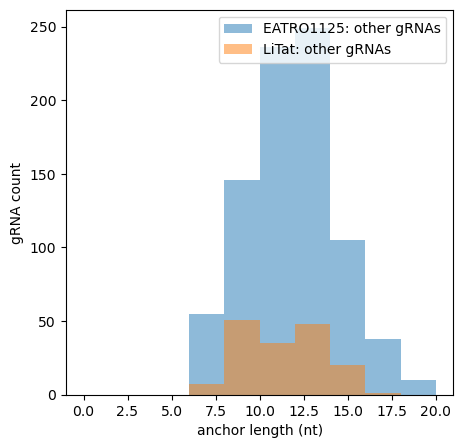

compare EATRO1125 and LiTat A6/RPS12 gRNAs anchor_len
11.540372670807454 2.5843858705645197
12.1875 3.2260559060346057
TtestResult(statistic=-1.902313799178567, pvalue=0.057848108647202655, df=400.0)


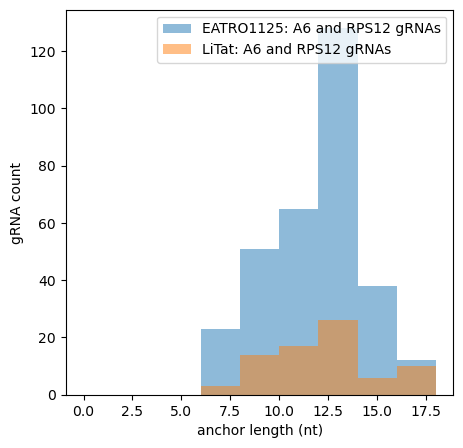

compare EATRO1125 and LiTat OTHER gRNAs mismatches
0.5369047619047619 0.787912218676442
0.5449101796407185 0.8829481477656197
TtestResult(statistic=-0.1174636808736431, pvalue=0.9065160934981941, df=1005.0)


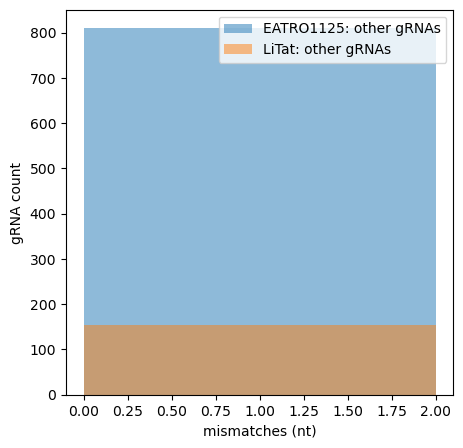

compare EATRO1125 and LiTat A6/RPS12 gRNAs mismatches
0.4720496894409938 0.7325295379730558
0.4 0.7564072307521771
TtestResult(statistic=0.7822469100169865, pvalue=0.4345322937167414, df=400.0)


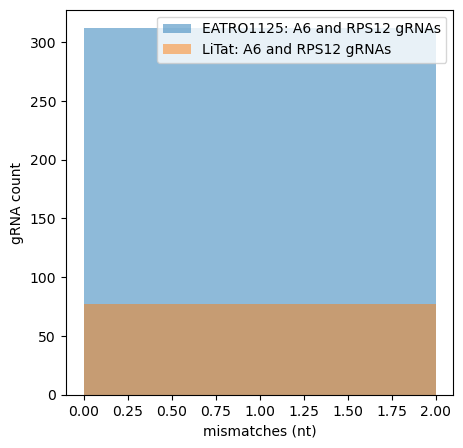

In [27]:
# Litat vs EATRO1125
comparison_between_isolates(grna_eatro1125,grna_litat,'EATRO1125','LiTat','length','gRNA length')
comparison_between_isolates(grna_eatro1125,grna_litat,'EATRO1125','LiTat','anchor_len','anchor length')
comparison_between_isolates(grna_eatro1125,grna_litat,'EATRO1125','LiTat','mismatches','mismatches')

41.2625 4.536054578512092
38.455089820359284 5.850246196885466
TtestResult(statistic=3.7807421843553826, pvalue=0.0001964868387049928, df=245.0)


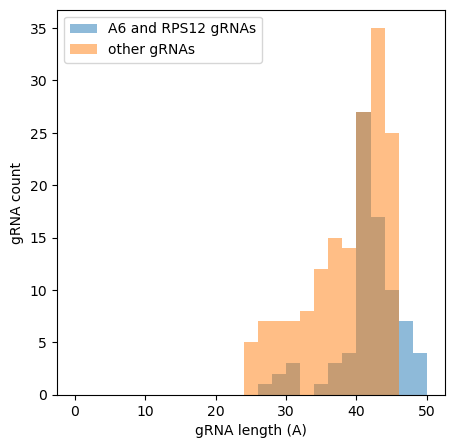

12.1875 3.2260559060346057
11.071856287425149 2.6966486614534464
TtestResult(statistic=2.8509361441743697, pvalue=0.004730558101465045, df=245.0)


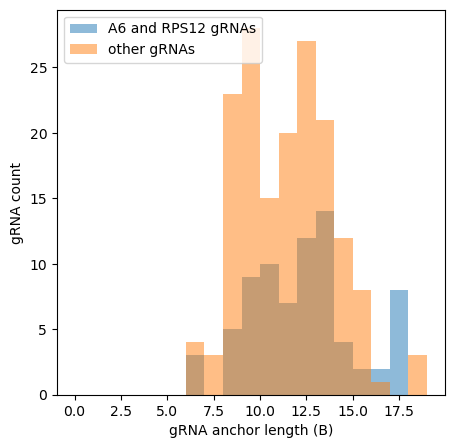

0.4 0.7564072307521771
0.5449101796407185 0.8829481477656197
TtestResult(statistic=-1.262403490065739, pvalue=0.20800394251447724, df=245.0)


In [28]:
#analysis with LiTat-1-3
#length of gRNAs 
lena6rps12={g:int(v['length']) for g,v in grna_litat.items() if v['product'] in ['A6','RPS12']}
lenother={g:int(v['length']) for g,v in grna_litat.items() if v['product'] not in ['A6','RPS12']}
print(sum(lena6rps12.values())/len(lena6rps12),statistics.stdev(lena6rps12.values()))
print(sum(lenother.values())/len(lenother),statistics.stdev(lenother.values()))
a=ttest_ind(list(lena6rps12.values()),list(lenother.values()))
print(a)
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5, 5), sharey=True)
axs.hist(lena6rps12.values(),bins=range(0,round(max(lena6rps12.values())),2),alpha=0.5,label='A6 and RPS12 gRNAs')
axs.hist(lenother.values(),bins=range(0,round(max(lenother.values())),2),alpha=0.5,label= 'other gRNAs')
axs.set_xlabel('gRNA length (A)')
axs.set_ylabel('gRNA count')
axs.legend()
plt.show()
#
#length of gRNAs anchor
lena6rps12={g:int(v['anchor_len']) for g,v in grna_litat.items() if v['product'] in ['A6','RPS12']}
lenother={g:int(v['anchor_len']) for g,v in grna_litat.items() if v['product'] not in ['A6','RPS12']}
print(sum(lena6rps12.values())/len(lena6rps12),statistics.stdev(lena6rps12.values()))
print(sum(lenother.values())/len(lenother),statistics.stdev(lenother.values()))
a=ttest_ind(list(lena6rps12.values()),list(lenother.values()))
print(a)
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5, 5), sharey=True)
axs.hist(lena6rps12.values(),bins=range(0,round(max(lena6rps12.values())),1),alpha=0.5,label='A6 and RPS12 gRNAs')
axs.hist(lenother.values(),bins=range(0,round(max(lenother.values())),1),alpha=0.5,label= 'other gRNAs')
axs.set_xlabel('gRNA anchor length (B)')
axs.set_ylabel('gRNA count')
axs.legend()
plt.show()
#mismatches
lena6rps12={g:int(v['mismatches']) for g,v in grna_litat.items() if v['product'] in ['A6','RPS12']}
lenother={g:int(v['mismatches']) for g,v in grna_litat.items() if v['product'] not in ['A6','RPS12']}
print(sum(lena6rps12.values())/len(lena6rps12),statistics.stdev(lena6rps12.values()))
print(sum(lenother.values())/len(lenother),statistics.stdev(lenother.values()))
a=ttest_ind(list(lena6rps12.values()),list(lenother.values()))
print(a)


In [29]:
#cassettes
eatro1125cassetteratio=[396,376,17,373,156]
print([round(i/1318*100,2) for i in eatro1125cassetteratio ])
lena6rps12={g:v['cassette_label'] for g,v in grna_OVI.items() if v['product'] in ['A6','RPS12']}
cascount1={i:list(lena6rps12.values()).count(i) for i in set(lena6rps12.values())}
print(cascount1,'\n',{k: round(v/len(lena6rps12)*100,2) for k,v in cascount1.items()})
lenother={g:v['cassette_label'] for g,v in grna_OVI.items() if v['product'] not in ['A6','RPS12']}
cascount2={i:list(lenother.values()).count(i) for i in set(lenother.values())}
print(cascount2,'\n',{k: round(v/len(lenother)*100,2) for k,v in cascount2.items()})
#chisquare proportion test: A6 RPS12
chisequare_func(14,72,396,1318) #
chisequare_func(27,72,396,1318)
#chisequare test: other
print('other gRNAs')
chisequare_func(24,78,396,1318) #
chisequare_func(20,78,396,1318)
chisequare_func(2,78,396,1318) #
chisequare_func(21,78,396,1318)
chisequare_func(6,78,396,1318) #

[30.05, 28.53, 1.29, 28.3, 11.84]
{'IV': 27, 'I': 14, 'II': 24, 'V': 8} 
 {'IV': 36.99, 'I': 19.18, 'II': 32.88, 'V': 10.96}
{'I': 24, 'IV': 22, 'Maxi': 1, 'Orphan': 3, 'V': 6, 'III': 3, 'II': 20} 
 {'I': 30.38, 'IV': 27.85, 'Maxi': 1.27, 'Orphan': 3.8, 'V': 7.59, 'III': 3.8, 'II': 25.32}
Power_divergenceResult(statistic=3.8497928185202235, pvalue=0.049752136007389626)
Power_divergenceResult(statistic=1.9035816407020305, pvalue=0.16767796680960936)
other gRNAs
Power_divergenceResult(statistic=0.01943681770145975, pvalue=0.8891214391648964)
Power_divergenceResult(statistic=0.7199330756814488, pvalue=0.3961658624171054)
Power_divergenceResult(statistic=28.027069178912996, pvalue=1.19630283577868e-07)
Power_divergenceResult(statistic=0.36181732222946983, pvalue=0.547498669568744)
Power_divergenceResult(statistic=18.542971850997883, pvalue=1.661165959714462e-05)


In [30]:
strain_mrna={s:{k:sorted(strain_mrna[s][k],key=lambda x:x[1],reverse=False) for k in strain_mrna[s]} for s in strain_mrna}

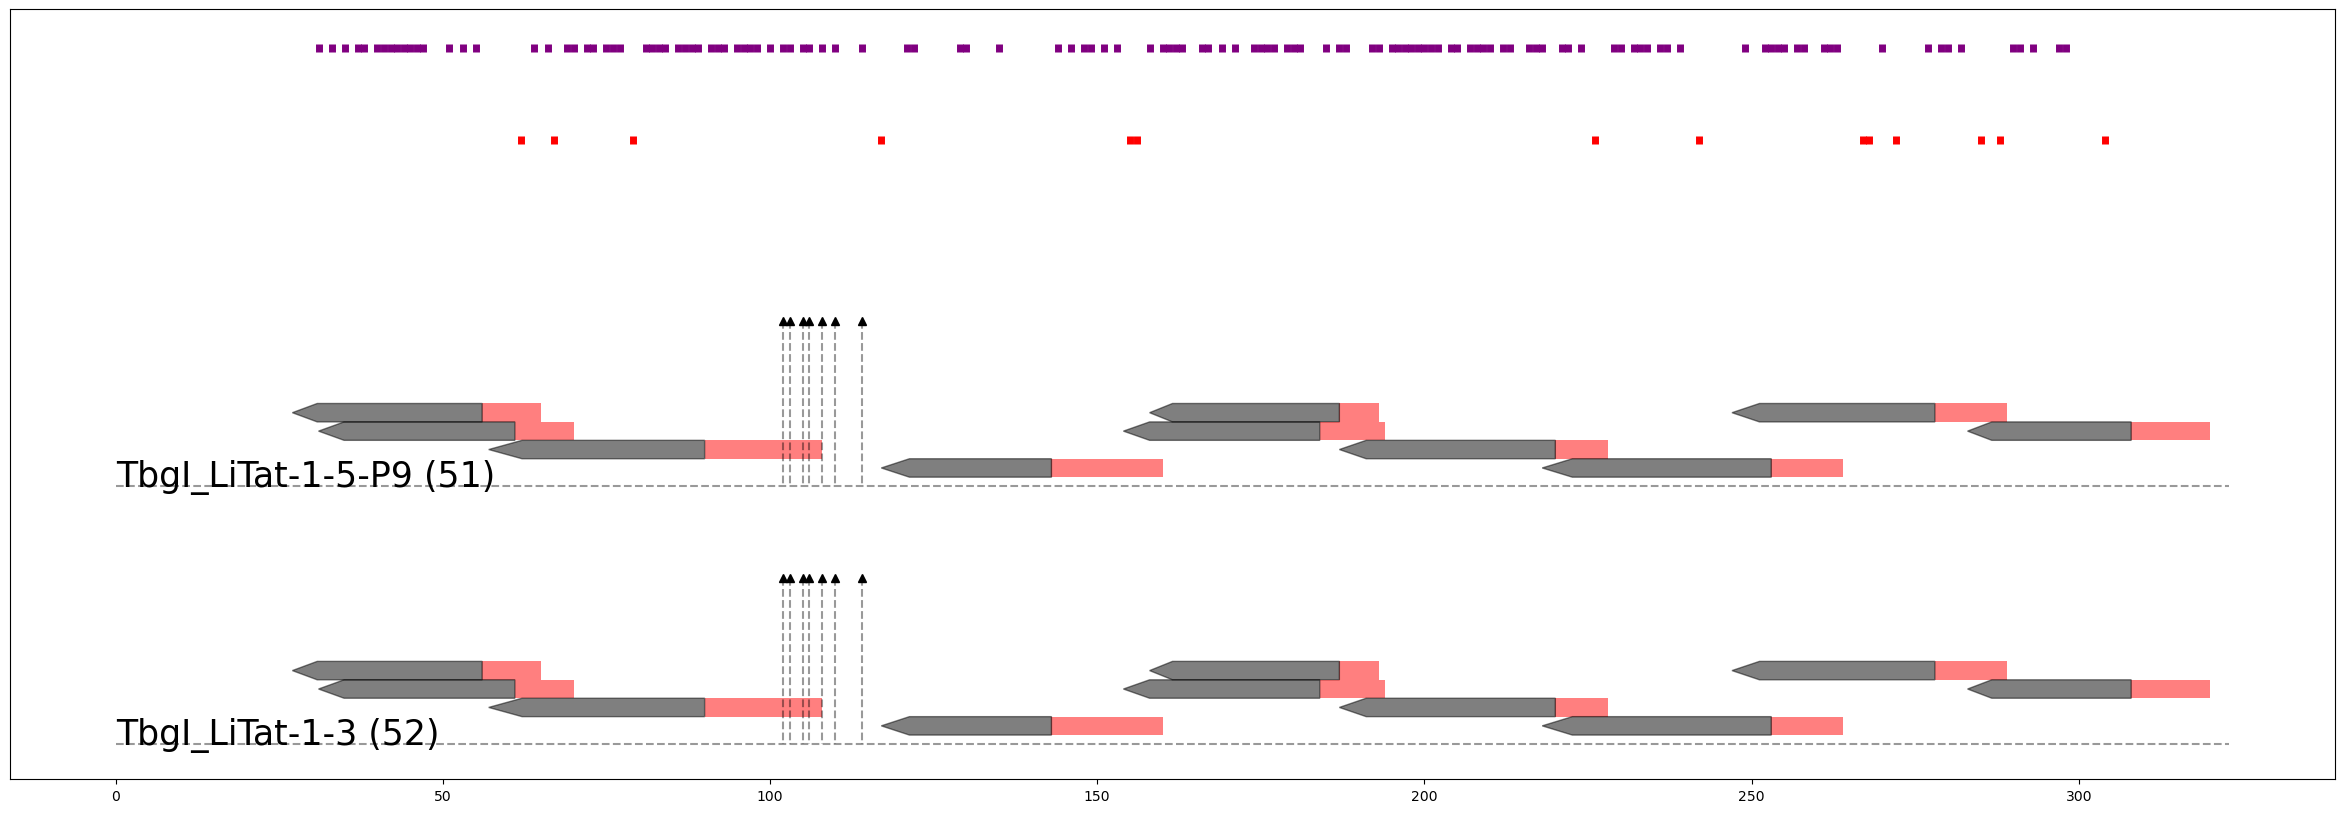

In [31]:
a6=plot_mRNA_gRNA({k:strain_mrna[k] for k in ['TbgI_LiTat-1-5-P9','TbgI_LiTat-1-3']},mini_dict,'RPS12',
                     y=-3.3,fold=3,figw=30,figh=10,output='A6_v1_gRNA_coverage_1')

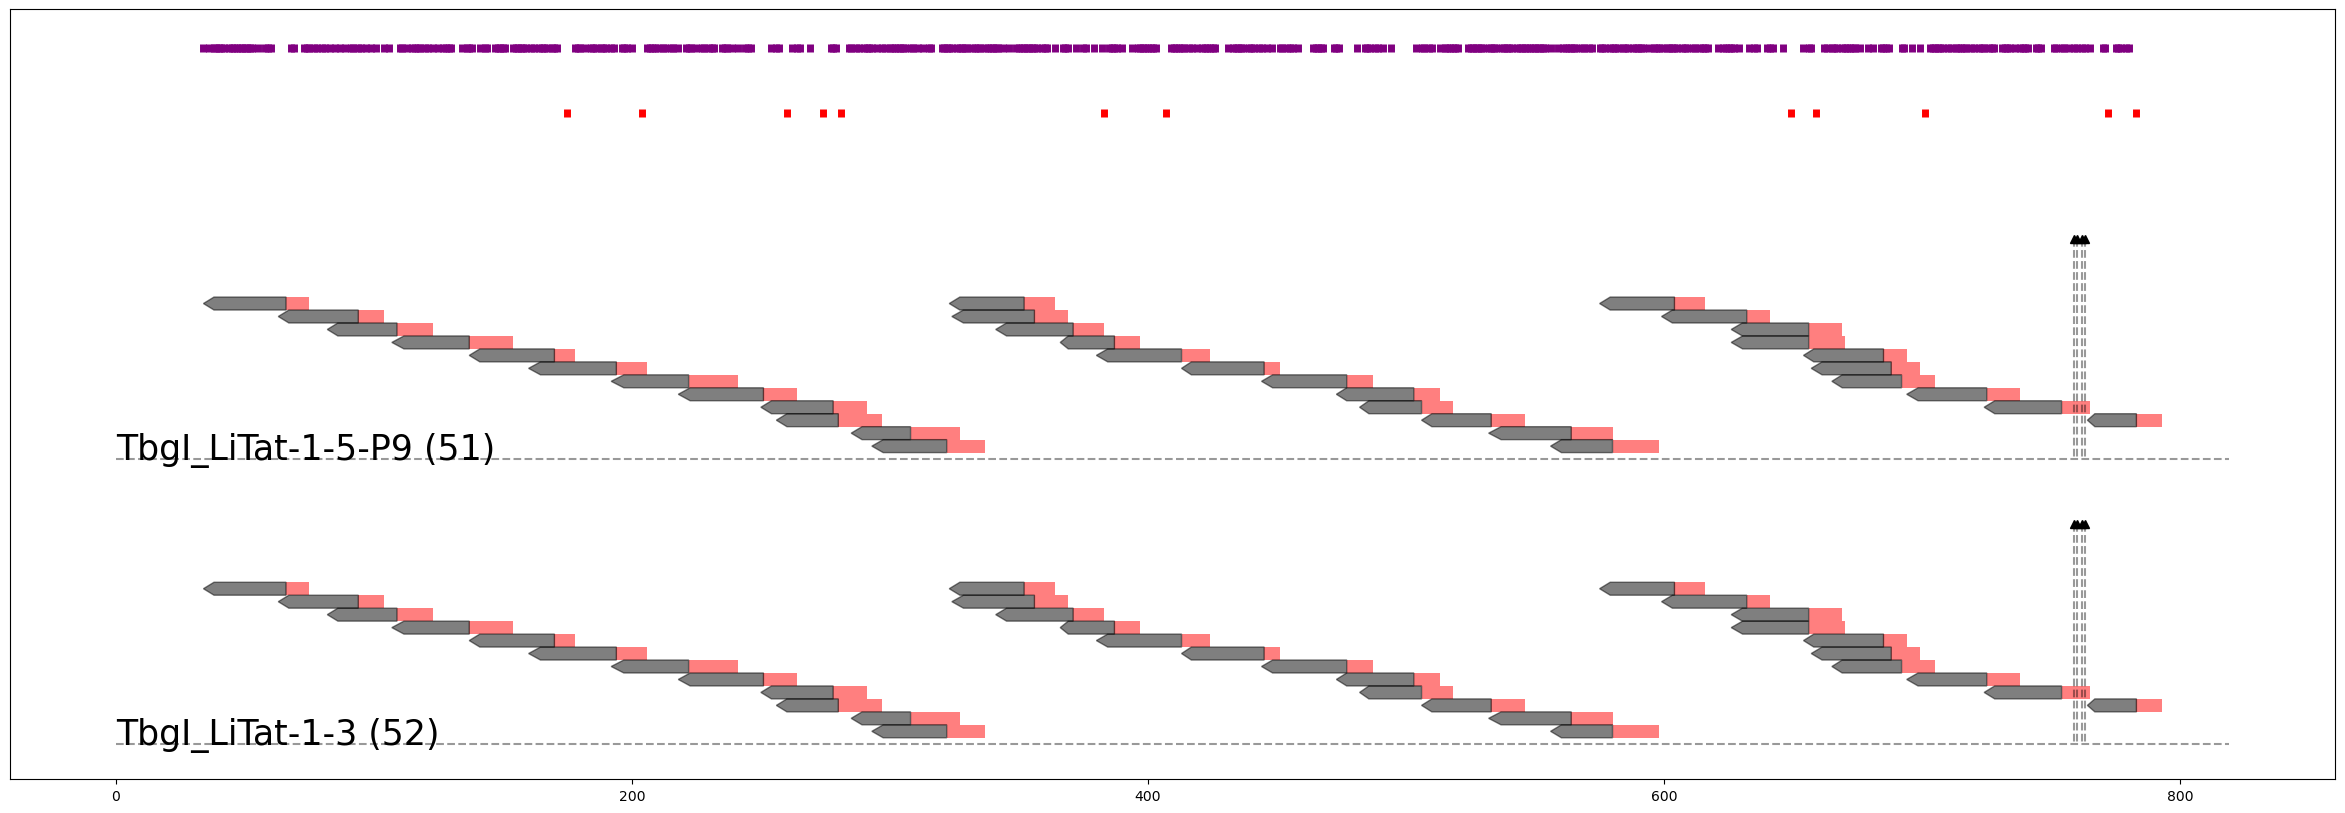

In [32]:
a6=plot_mRNA_gRNA({k:strain_mrna[k] for k in ['TbgI_LiTat-1-5-P9','TbgI_LiTat-1-3']},mini_dict,'A6_v2',
                     y=-3.3,fold=3,figw=30,figh=10,output='A6_v1_gRNA_coverage_1')

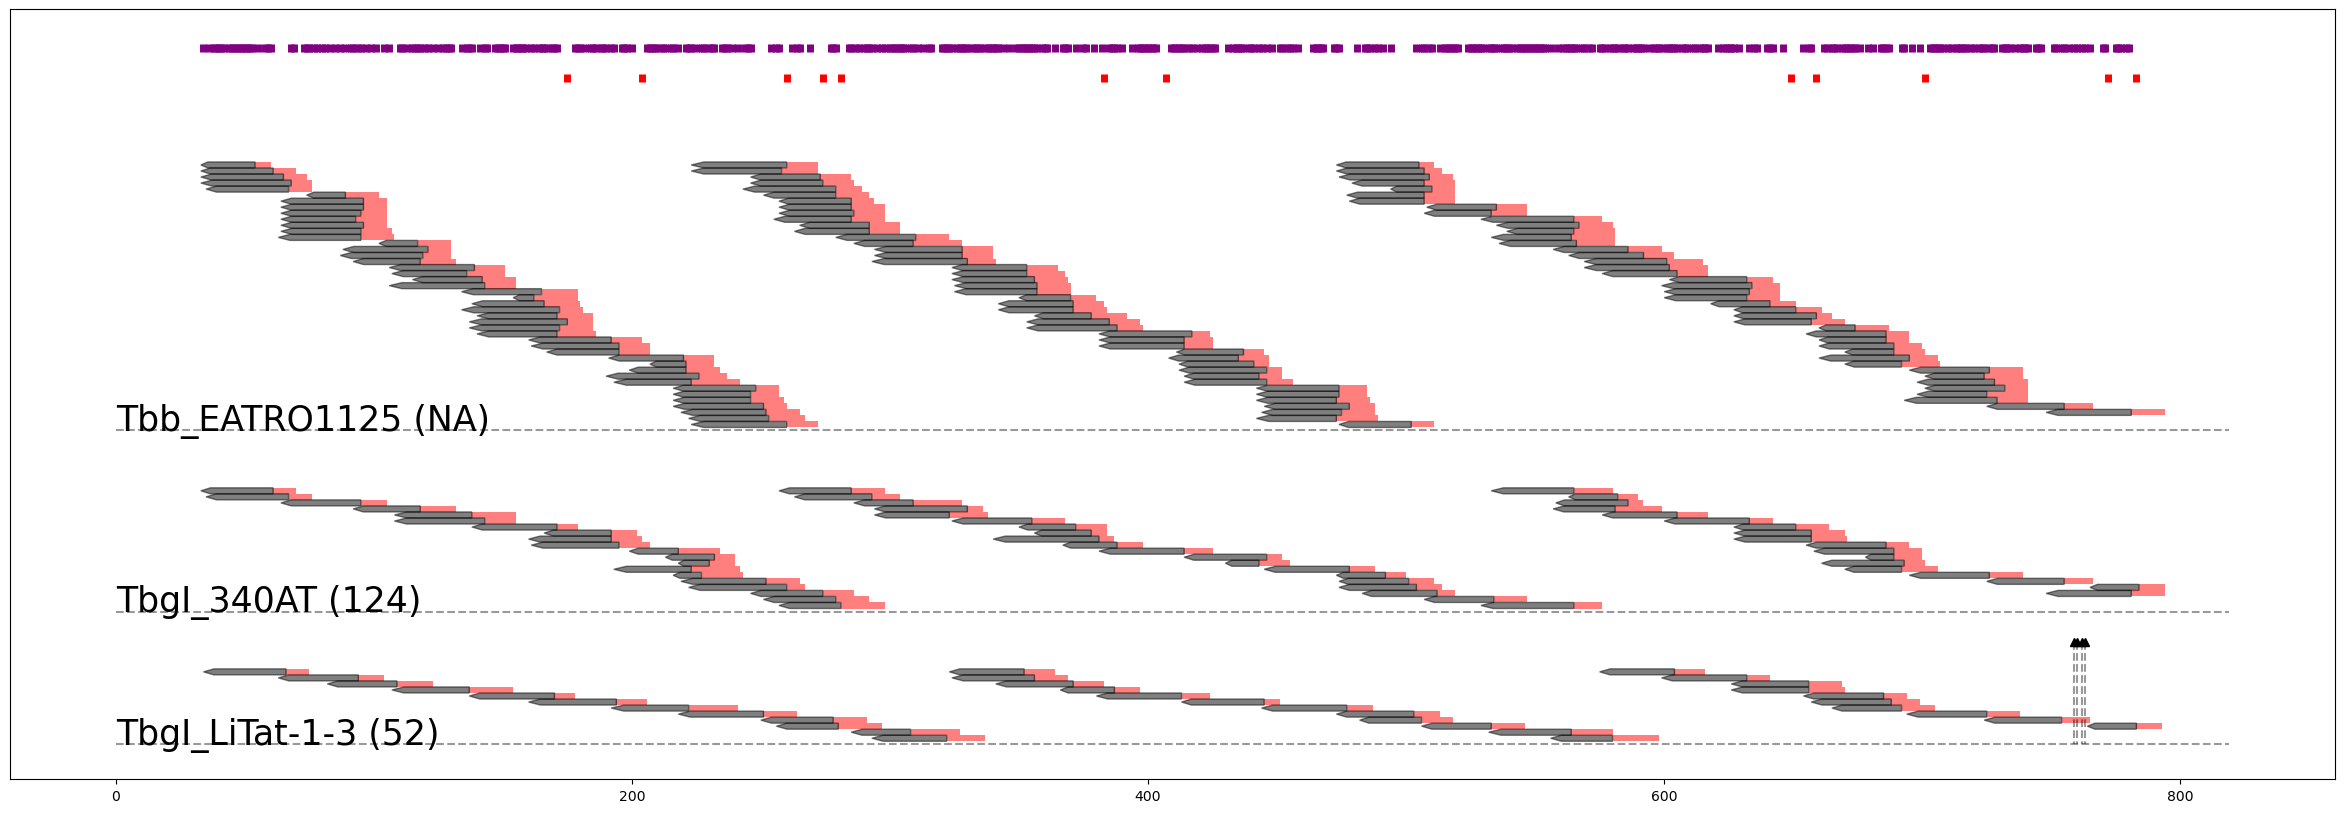

In [33]:
a6=plot_mRNA_gRNA({k:strain_mrna[k] for k in ['Tbb_EATRO1125','TbgI_340AT','TbgI_LiTat-1-3']},mini_dict,'A6_v2',
                     y=-3.3,fold=3,figw=30,figh=10,output='A6_v1_gRNA_coverage_1')

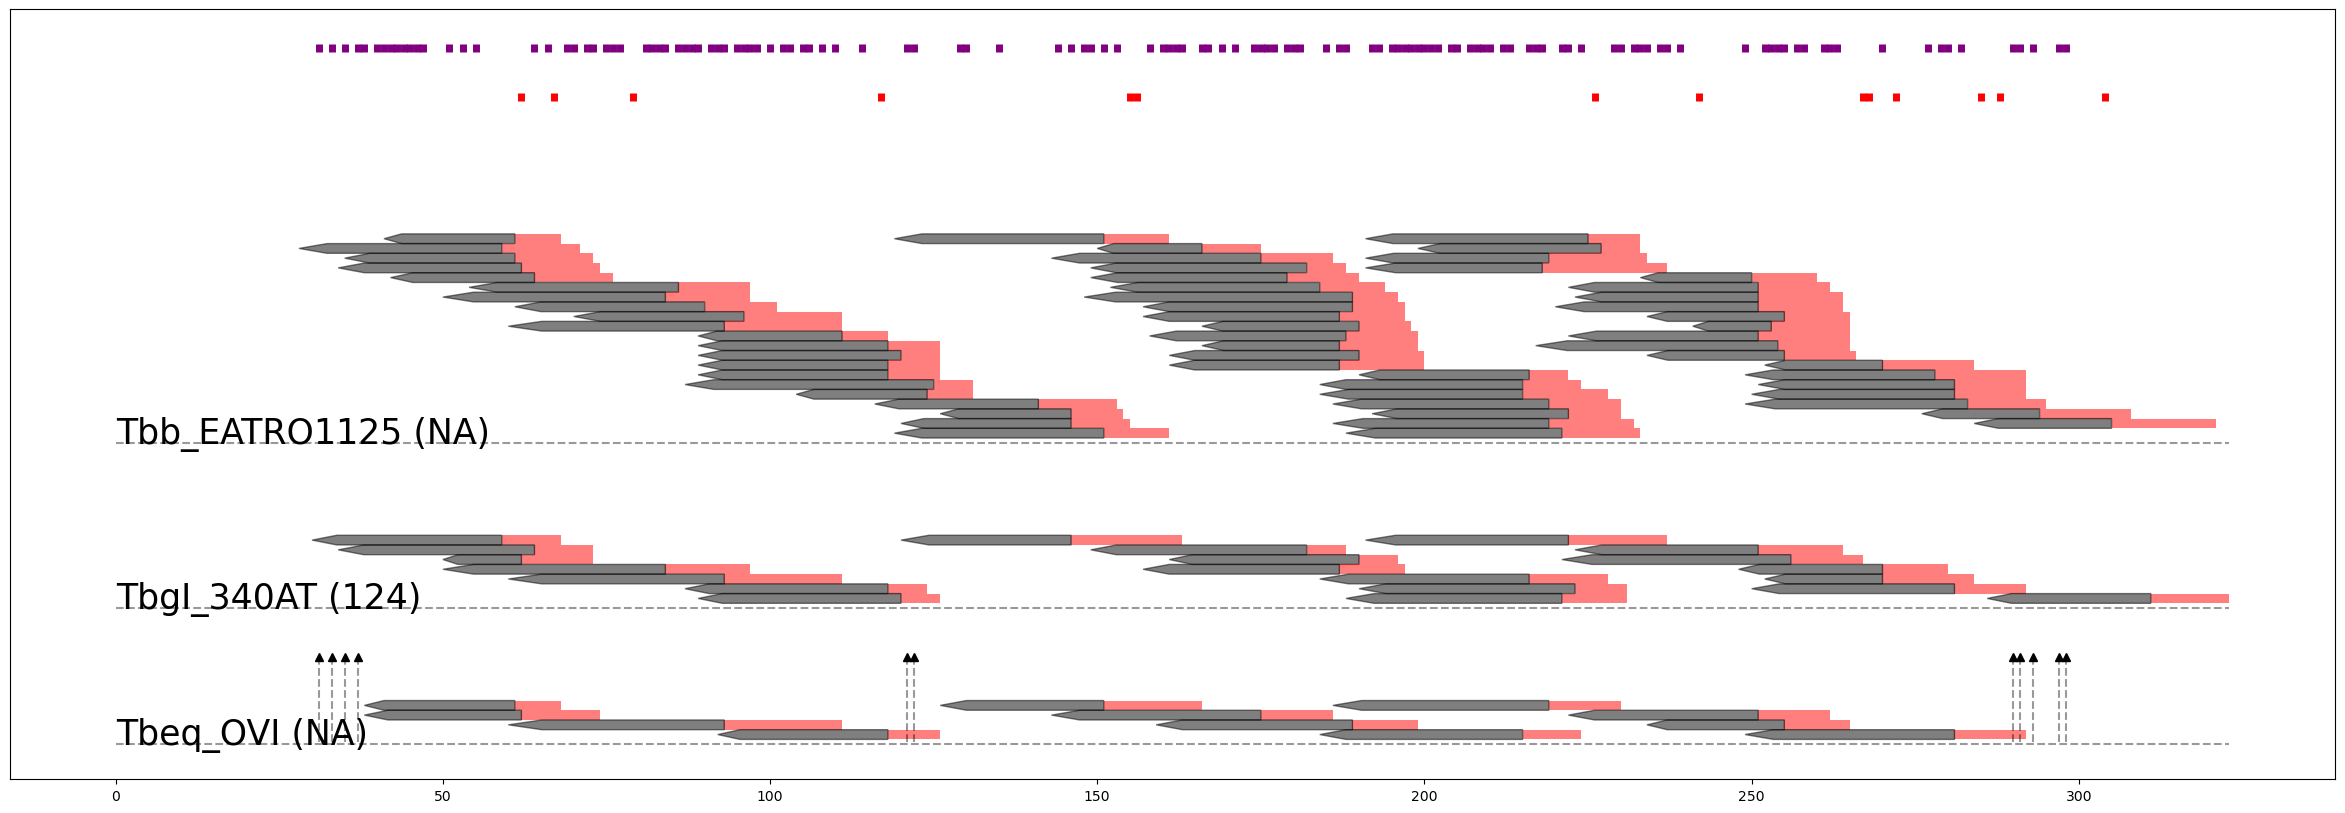

In [34]:
rps12=plot_mRNA_gRNA({k:strain_mrna[k] for k in ['Tbb_EATRO1125','TbgI_340AT','Tbeq_OVI']},mini_dict,'RPS12',
                     y=-3.3,fold=3,figw=30,figh=10,output='RPS12_gRNA_coverage_1')

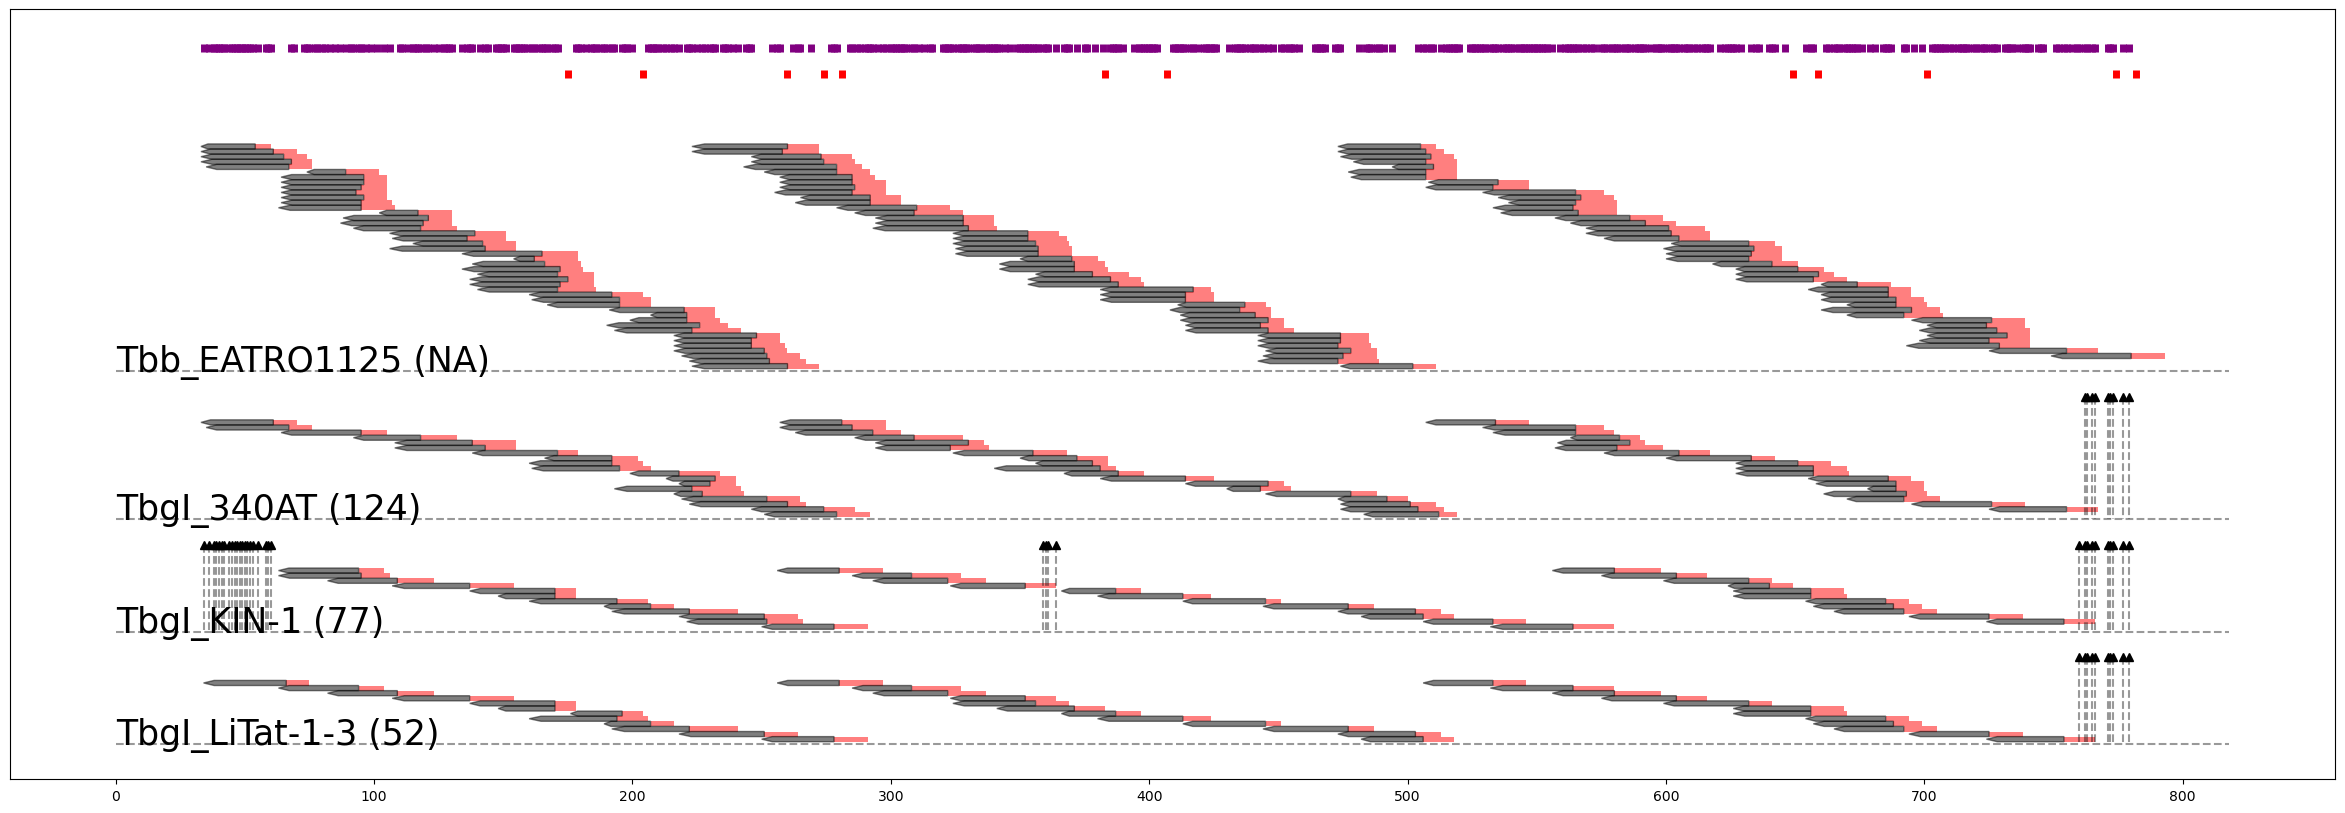

In [35]:
#plot Tbg1 strains and OVI
a6=plot_mRNA_gRNA({k:strain_mrna[k] for k in ['Tbb_EATRO1125','TbgI_340AT','TbgI_KIN-1','TbgI_LiTat-1-3']},mini_dict,'A6_v1',
                     y=-3.3,fold=3,figw=30,figh=10,output='A6_v1_gRNA_coverage_1')
#rps12=plot_mRNA_gRNA(selected_dict2,'RPS12',
#                     y=-3.3,fold=3,figw=30,figh=10,output='RPS12_gRNA_coverage_1')

In [36]:
#a6=plot_mRNA_gRNA(strain_mrna,mini_dict,'ND8_v2',
#                     y=-3.3,fold=3,figw=30,figh=200,output='A6_v1_gRNA_coverage_1')

In [37]:
#a6=plot_mRNA_gRNA(strain_mrna,mini_dict,'A6_v2',
#                     y=-3.3,fold=3,figw=30,figh=200,output='A6_v2_gRNA_coverage_1')

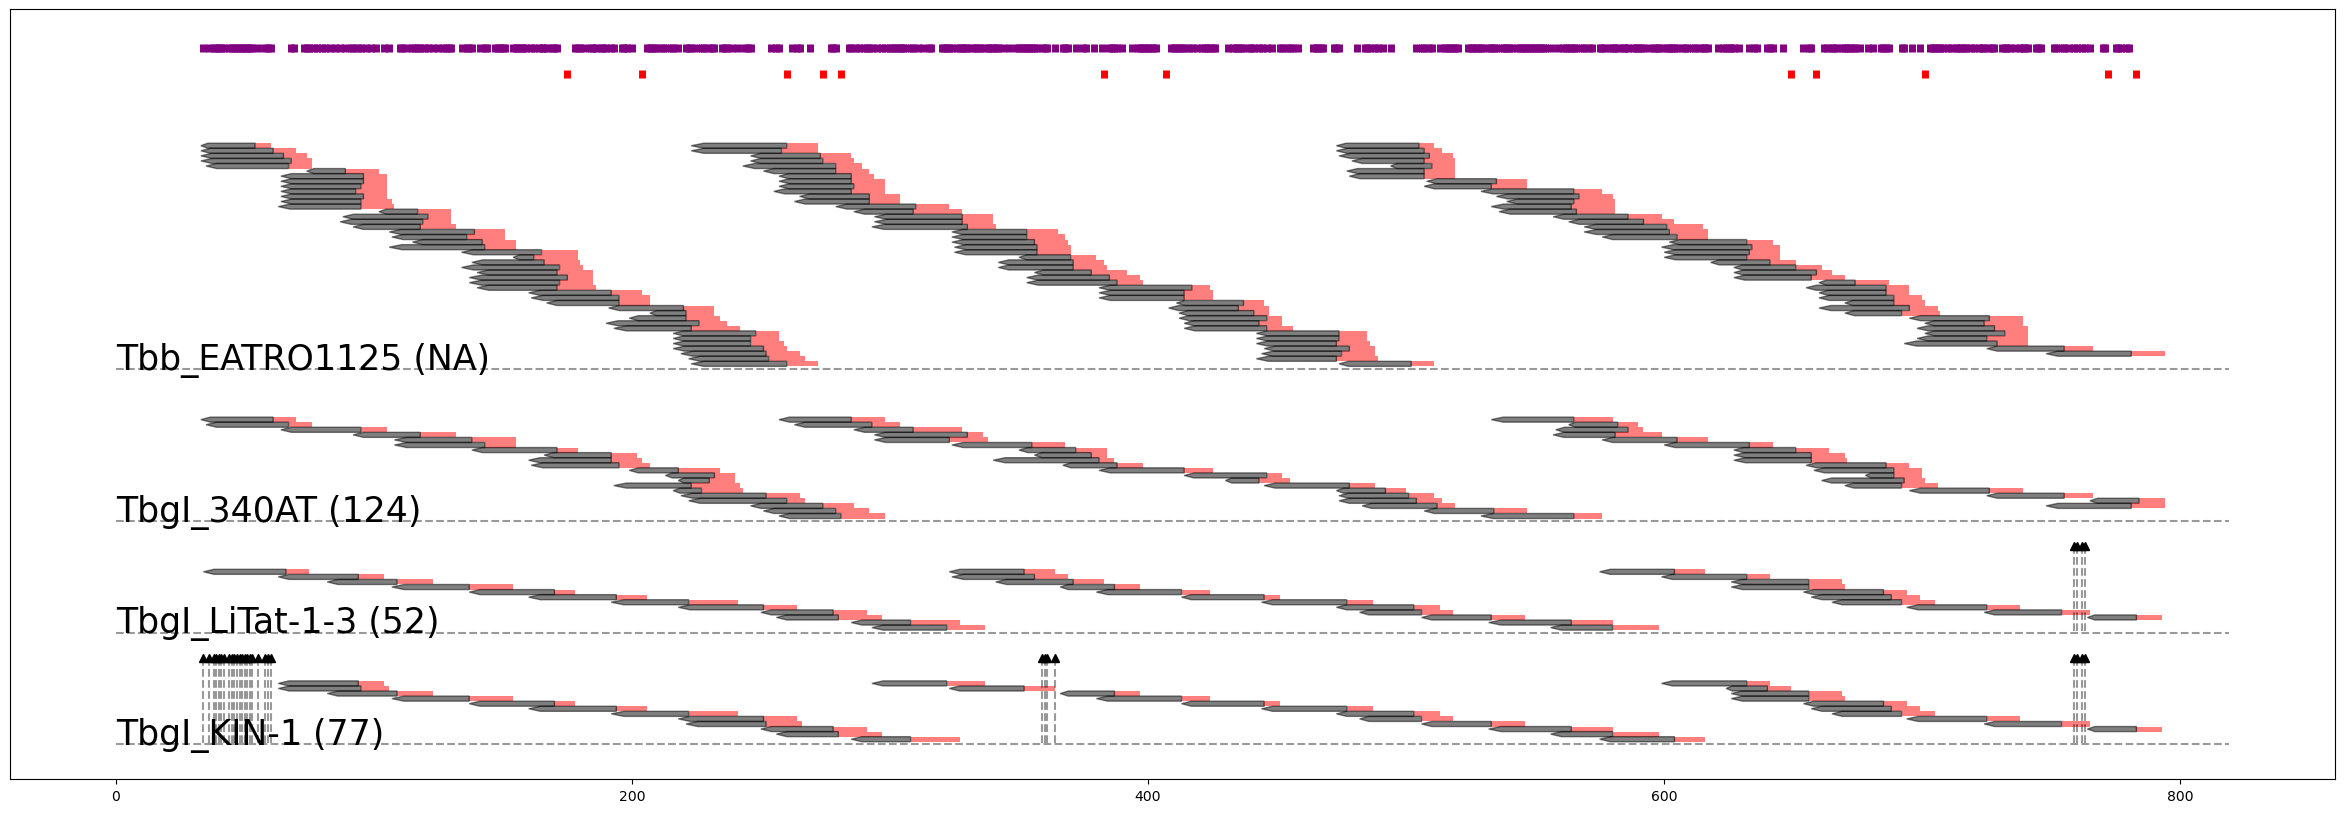

In [38]:
a6=plot_mRNA_gRNA({k:strain_mrna[k] for k in ['Tbb_EATRO1125','TbgI_340AT','TbgI_LiTat-1-3','TbgI_KIN-1']},mini_dict,'A6_v2',
                     y=-3.3,fold=3,figw=30,figh=10,output='A6_v2_gRNA_coverage_1')

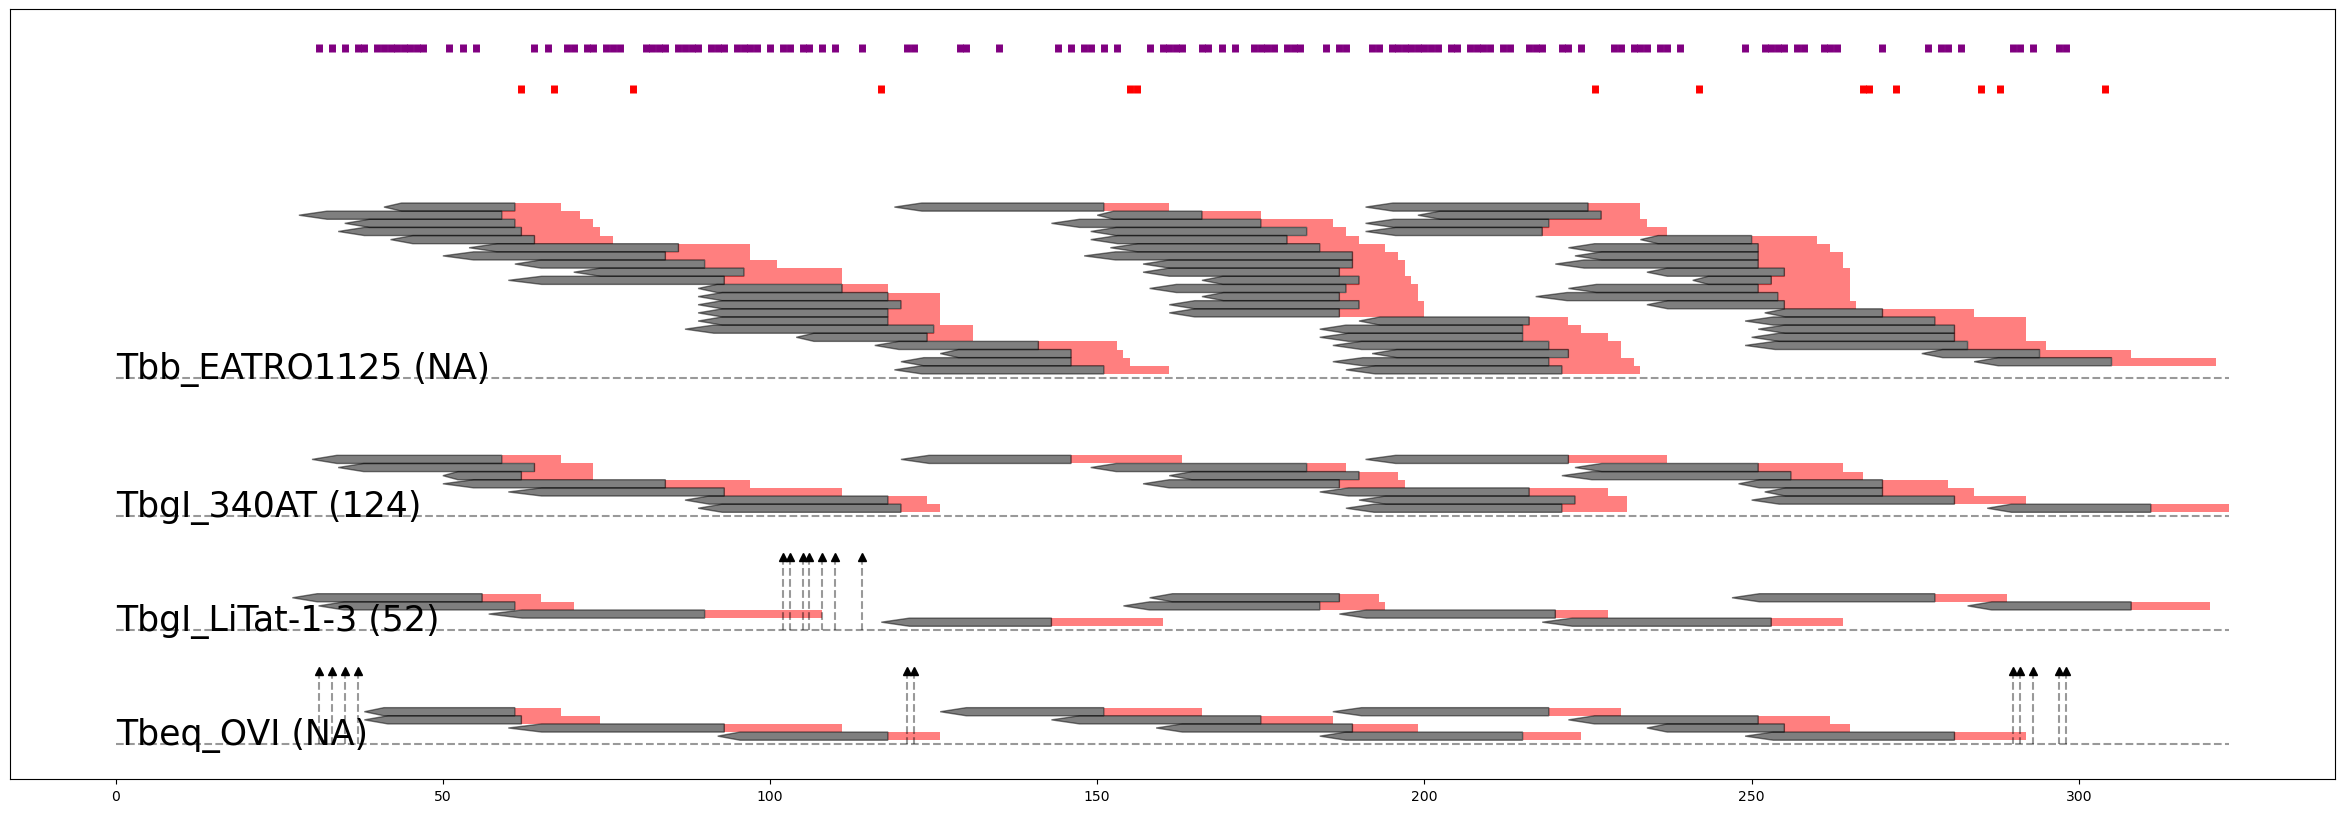

In [39]:
a6=plot_mRNA_gRNA({k:strain_mrna[k] for k in ['Tbb_EATRO1125','TbgI_340AT','TbgI_LiTat-1-3','Tbeq_OVI']},mini_dict,'RPS12',
                     y=-3.3,fold=3,figw=30,figh=10,output='RPS12_gRNA_coverage_1')

KeyError: 'COX3'

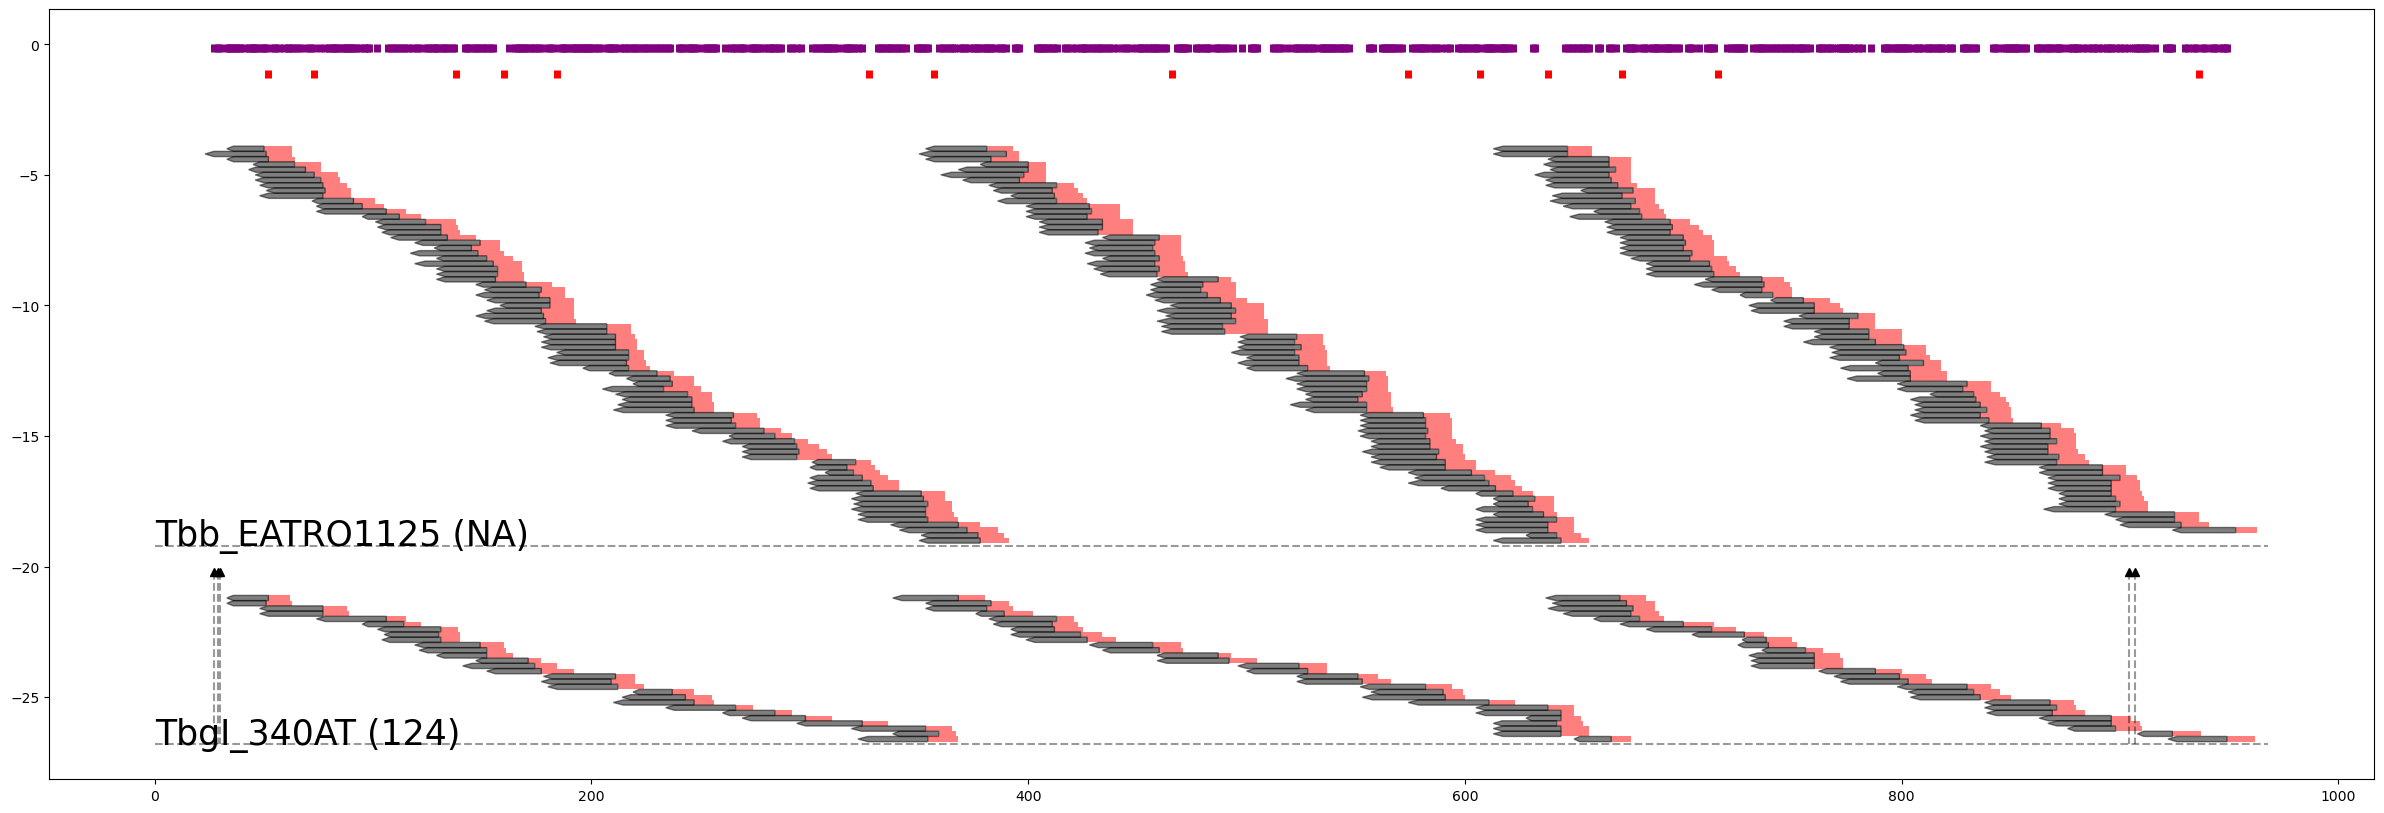

In [40]:
a6=plot_mRNA_gRNA({k:strain_mrna[k] for k in ['Tbb_EATRO1125','TbgI_340AT','TbgI_LiTat-1-3','Tbeq_OVI']},mini_dict,'COX3',
                     y=-3.3,fold=3,figw=30,figh=10,output='COX3_gRNA_coverage_1')

In [ ]:
#plot all Tbg1 strains and OVI
#a6=plot_mRNA_gRNA(strain_mrna,mini_dict,'COX3',
#                     y=-3.3,fold=3,figw=30,figh=200,output='COX3_gRNA_coverage_1')

In [ ]:
a6=plot_mRNA_gRNA(selected_dict,mini_dict,'RPS12',
                     y=-3.3,fold=3,figw=30,figh=10,output='RPS12_gRNA_coverage_1')

In [ ]:
a6=plot_mRNA_gRNA(selected_dict,mini_dict,'CR3',
                     y=-3.3,fold=3,figw=30,figh=10,output='CR3_gRNA_coverage_1')

In [ ]:
a6=plot_mRNA_gRNA(selected_dict,mini_dict,'CR4',
                     y=-3.3,fold=3,figw=30,figh=10,output='CR4_gRNA_coverage_1')

In [ ]:
a6=plot_mRNA_gRNA(selected_dict,mini_dict,'CYB',
                     y=-3.3,fold=3,figw=30,figh=10,output='CYB_gRNA_coverage_1')

In [ ]:
a6=plot_mRNA_gRNA(selected_dict,mini_dict,'ND3',
                     y=-3.3,fold=3,figw=30,figh=10,output='ND3_gRNA_coverage_1')

In [ ]:
a6=plot_mRNA_gRNA(selected_dict,mini_dict,'ND7',
                     y=-3.3,fold=3,figw=30,figh=10,output='ND7_gRNA_coverage_1')

In [ ]:
a6=plot_mRNA_gRNA(selected_dict,mini_dict,'ND8_v1',
                     y=-3.3,fold=3,figw=30,figh=10,output='ND8_v1_gRNA_coverage_1')

In [ ]:
rps12=plot_mRNA_gRNA('/home/jovyan/gRNAs/RPS12.txt',dict_list[0],'RPS12',
                     y=-3.3,fold=3,figw=30,figh=25,output='RPS12_gRNA_coverage_1')

In [ ]:
rps12=plot_mRNA_gRNA('/home/jovyan/gRNAs/RPS12.txt',dict_list[1],'RPS12',
                     y=-3.3,fold=3,figw=30,figh=25,output='RPS12_gRNA_coverage_1')

In [ ]:
rps12=plot_mRNA_gRNA('/home/jovyan/gRNAs/RPS12.txt',dict_list[2],'RPS12',
                     y=-3.3,fold=3,figw=30,figh=25,output='RPS12_gRNA_coverage_1')

In [ ]:
rps12=plot_mRNA_gRNA('/home/jovyan/gRNAs/RPS12.txt',dict_list[3],'RPS12',
                     y=-3.3,fold=3,figw=30,figh=25,output='RPS12_gRNA_coverage_1')

In [ ]:
rps12=plot_mRNA_gRNA('/home/jovyan/gRNAs/RPS12.txt',dict_list[4],'RPS12',
                     y=-3.3,fold=3,figw=30,figh=25,output='RPS12_gRNA_coverage_1')

In [ ]:
rps12=plot_mRNA_gRNA('/home/jovyan/gRNAs/RPS12.txt',dict_list[5],'RPS12',
                     y=-3.3,fold=3,figw=30,figh=25,output='RPS12_gRNA_coverage_1')

In [ ]:
rps12=plot_mRNA_gRNA('/home/jovyan/gRNAs/RPS12.txt',dict_list[6],'RPS12',
                     y=-3.3,fold=3,figw=30,figh=25,output='RPS12_gRNA_coverage_1')

In [ ]:
rps12=plot_mRNA_gRNA('/home/jovyan/gRNAs/RPS12.txt',dict_list[7],'RPS12',
                     y=-3.3,fold=3,figw=30,figh=25,output='RPS12_gRNA_coverage_1')

In [ ]:
rps12=plot_mRNA_gRNA('/home/jovyan/gRNAs/RPS12.txt',dict_list[8],'RPS12',
                     y=-3.3,fold=3,figw=30,figh=25,output='RPS12_gRNA_coverage_1')

In [ ]:
rps12=plot_mRNA_gRNA('/home/jovyan/gRNAs/RPS12.txt',dict_list[9],'RPS12',
                     y=-3.3,fold=3,figw=30,figh=25,output='RPS12_gRNA_coverage_1')

In [ ]:
rps12=plot_mRNA_gRNA('/home/jovyan/gRNAs/RPS12.txt',dict_list[10],'RPS12',
                     y=-3.3,fold=3,figw=30,figh=25,output='RPS12_gRNA_coverage_1')